In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from os import mkdir
from os.path import isdir
from pickle import dump
import imp
import os
from datetime import datetime
import glob, os
from scipy import signal

import sys
sys.path.insert(1, 'scripts/')
import pipeline_helper as helper
from utilities import processed_data_dir, logger
from raw_tbb_IO import MultiFile_Dal1, filePaths_by_stationName
import findRFI
import utilities
import event
import signal_processing
import metadata
import calibration as cal
import beamformer
import antenna_model
import directionfitbf
import planewave
from scipy.signal import hilbert, chirp


# Create event
* find LORA+radio files

# Loop over stations
* Find deviating antennas
* Find block + position of pulse from LORA time
* Filter data
* Clean RFI
* Calibration (relative and absolute)
* More timing corrections?
* Beamform in LORA direction to identify if CR is found
* Unfold antenna repsonse in iterative loop with planewave fit
* Find integrated power for station (xyz, 01)
* Find stoke's parameters
* Save all data for this station¶

# With data from all stations
* Run LDF
* Run polarizatin
* Run wavefront fit
* Save all event data

In [2]:
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"  #this is necessary to read files

In [3]:
block_size=int(2 ** 16)
broad_search_window_width=2 ** 13
snr_cut=3

#output_dir='/home/hpandya/data_storage/temp/'
radio_directory='/vol/astro3/lofar/vhecr/lora_triggered/data/'
particle_directory='/vol/astro3/lofar/vhecr/lora_triggered/LORA/'

# Create event

This can be done by event ID, and the event ID can be found from a timestamp or filename (ie 'D20150829T170709') by using 
* pipeline_helper.ID_from_UTC(timestamp) or
* pipeline_helper.ID_from_YMDHMS(YMDHMS)


In [17]:
#92380604 -> good event!

id=216660305
timestamp=id+1262304000
ev=event.Event(id)

# don't worry about output directory for now
#directory = os.path.join(output_dir, str(id))
#if not os.path.exists(directory):
#    os.makedirs(directory)

#event_plot_prefix = os.path.join(directory, "cr_physics-{0}-".format(id))

In [18]:
# find relevant data files
radio_file_tag,particle_file_tag=helper.return_file_by_LOFAR_ID(id)
print(radio_file_tag)
print(particle_file_tag)

D20161112T152505
LORAdata-20161112T152505.dat


In [19]:
radio_files=helper.return_station_files(radio_file_tag)
stations=helper.return_stations(radio_files)
lora_file=helper.return_lora_file(particle_file_tag)
lora_direction=helper.return_lora_direction(lora_file)


In [20]:
os.path.getsize(radio_files[0])/(1024**2) # MB

76.79682922363281

# Loop over stations

This will become a loop where each station with a data file is examined.  There is a station class which will hold all information for one station

In [21]:
s=3
station=stations[s]
print('Station name: ', station)
pulse_direction = lora_direction
ev.lora_direction=lora_direction
print("Initial pulse direction from LORA", pulse_direction)
#station_plot_prefix = event_plot_prefix + "{0}-".format(station)
TBB_data = MultiFile_Dal1([radio_files[0]])
print("Antenna set: ",TBB_data.antennaSet)
    
nBlocks=np.ceil(TBB_data.DataLengths[0]/block_size)
all_dipoles = [int(x) % 100 for x in TBB_data.dipoleNames]
antennas_missing_dipole = [x for x in all_dipoles if (x + (1 - 2*(x%2))) not in all_dipoles]
print('missing dipoles? : ',antennas_missing_dipole)
    
sample_number_per_antenna = TBB_data.SampleNumbers
    
median_sample_number = np.median(sample_number_per_antenna)

median_data_length = np.median(TBB_data.DataLengths)
deviating_antennas = np.where( np.abs(sample_number_per_antenna - median_sample_number) > median_data_length/4)[0]

   
deviating_antennas_starting_later = np.where( sample_number_per_antenna > median_sample_number )[0]
deviating_antennas = np.unique(np.concatenate( (deviating_antennas, deviating_antennas_starting_later)))
    
data_length_per_antenna = TBB_data.DataLengths
max_data_length = np.max(TBB_data.DataLengths)

print('Number of deviating antennas (SAMPLE_NUMBER): %d' % len(deviating_antennas))

# FIX Oct 23, 2019
#more_deviating_antennas = np.where( data_length_per_antenna < max_data_length)[0]
more_deviating_antennas = np.where( np.abs(data_length_per_antenna - median_data_length) > median_data_length / 10)[0]

print('Number of deviating antennas (DATA_LENGTH): %d' % len(more_deviating_antennas))
deviating_antennas = np.unique(np.concatenate( (deviating_antennas, more_deviating_antennas)) )
            # END FIX

nof_deviating_antennas = len(deviating_antennas) + len(antennas_missing_dipole)
print('Number of deviating antennas (total, unique): %d' % nof_deviating_antennas)


    
print('Number of deviating antennas (total, unique): %d' % nof_deviating_antennas)
if nof_deviating_antennas > 8:
    raise StationError("Starting time (SAMPLE_NUMBER) deviates in %d > 8 antennas" % nof_deviating_antennas)
elif nof_deviating_antennas > 0:
    #print 'Warning: one RCU found with deviating SAMPLE_NUMBER'
    other_polarization_rcus = []
    for thisRCU in deviating_antennas:
        # Remove this RCU and its odd/even counterpart from the selected_dipoles list
        # This prevents a read error later on
        if thisRCU % 2 == 0:
            other_polarization = thisRCU + 1
        else:
            other_polarization = thisRCU - 1
        if other_polarization not in other_polarization_rcus:
            other_polarization_rcus.append(other_polarization)
                            
    nof_antennas = len(sample_number_per_antenna)
    selected_dipoles = [i for i in range(nof_antennas) if (i not in deviating_antennas) and (i not in other_polarization_rcus) and (i not in antennas_missing_dipole)]
                #print 'Now selecting out RCUs %d and %d' % (thisRCU, other_polarization)
    print('Removing: %s' % deviating_antennas)
    print('Removing: %s' % other_polarization_rcus)
    print('Selected dipoles after removing %d rcus:' % (nof_antennas - len(selected_dipoles)))
         
            
tbb_time = TBB_data.Time
max_sample_number = max(TBB_data.SampleNumbers)
min_sample_number = min(TBB_data.SampleNumbers)

(tbb_time_sec, tbb_time_nsec)=helper.return_lora_time(particle_file_tag)
print('TBB time (from LORA): ',tbb_time_sec, tbb_time_nsec)

(block_number_lora, sample_number_lora) = helper.loraTimestampToBlocknumber(tbb_time_sec, tbb_time_nsec, tbb_time, max_sample_number, blocksize=block_size)
print('Block number, sample number: ', block_number_lora, sample_number_lora)
    
# Center readout block around LORA pulse location
shift = sample_number_lora - (block_size / 2)
pulse_search_window_start = (block_size / 2) - (broad_search_window_width / 2)
pulse_search_window_end = (block_size / 2) + (broad_search_window_width / 2)
# this shift is not currently actually implemented here- see further down
print('shifting block by {0} samples to center lora pulse at sample {1}'.format(shift, block_size / 2))

raw_data=np.zeros([len(all_dipoles),block_size])

for i in np.arange(len(all_dipoles)):    
    raw_data[i]=TBB_data.get_data( block_size*(block_number_lora), block_size, antenna_index=i)
    raw_data[i]=np.roll(raw_data[i], -1*int(shift))
clock_frequency=TBB_data.SampleFrequency



Station name:  CS005
Initial pulse direction from LORA (289.94, 69.29)
Antenna set:  LBA_OUTER
missing dipoles? :  []
Number of deviating antennas (SAMPLE_NUMBER): 0
Number of deviating antennas (DATA_LENGTH): 0
Number of deviating antennas (total, unique): 0
Number of deviating antennas (total, unique): 0
TBB time (from LORA):  1478964305.0 567412187.0
Block number, sample number:  3 7925
shifting block by -24843.0 samples to center lora pulse at sample 32768.0


In [22]:







# make simple bandpass filter
frequencies = np.fft.rfftfreq(block_size, d=5e-9)
bandpass_filter = signal_processing.simple_bandpass(frequencies)

# Do RFI finding
This creates an RFI filter, copied from Brian's implementation

In [23]:
initial_block=0
num_blocks=nBlocks
RFI = findRFI.FindRFI(TBB_data, block_size, initial_block, int(num_blocks-1),max_blocks=(int(num_blocks)-1),verbose=True, num_dbl_z=1000)
RFI_filter = findRFI.window_and_filter(block_size, RFI, lower_filter=30E6, upper_filter=80E6)
block_number=block_number_lora


finding good blocks
Taking channel 19 as reference antenna
Doing block 0
Doing block 1
Doing block 2
Doing block 3
Doing block 4
Doing block 5
6 analyzed blocks 96 analyzed antennas out of 96


In [24]:
# filter RFI, shift pulse to center of block
# note: pulse isn't totally centered
# note: Not sure about edge effects from RFI removal- do the sample shift first?

#raw_data=np.zeros([len(all_dipoles),block_size])
filtered_data=np.zeros([len(all_dipoles),block_size])
RFI_filtered_data=np.zeros([len(all_dipoles),block_size])
raw_spectrum=np.zeros([len(all_dipoles),int(block_size/2+1)])
cleaned_amplitude_spectrum=np.zeros([len(all_dipoles),int(block_size/2+1)])
cleaned_spectrum=np.zeros([len(all_dipoles),int(block_size/2+1)])
cleaned_power=np.zeros([len(all_dipoles)])

for i in np.arange(len(all_dipoles)):
    #TBB_data.get_data( block_size*block_number_lora-1, block_size, antenna_index=i )
    
    #raw_data[i]=TBB_data.get_data( block_size*(block_number_lora), block_size, antenna_index=i)
    
    fft_temp = np.fft.rfft(raw_data[i])
    filtered = fft_temp*bandpass_filter
    filtered_data[i]=np.fft.irfft(filtered)
    RFI_filtered_data[i] = 2*np.real(RFI_filter.filter(raw_data[i])) ## this works for multiple antennas as well, (like done at bottom of raw_tbb_IO.py)
    raw_spectrum[i]=2*np.abs(np.fft.rfft(raw_data[i]))
    cleaned_amplitude_spectrum[i]=2*np.abs(np.fft.rfft(RFI_filtered_data[i]))
    cleaned_spectrum[i]=2*np.abs(np.fft.rfft(RFI_filtered_data[i]))**2
    cleaned_power[i]=np.sum(cleaned_spectrum[i])
    #NOTE: check normalization of FFTs
    #raw_data[i]=np.roll(raw_data[i], -1*int(shift))
    #filtered_data[i]=np.roll(filtered_data[i], -1*int(shift))
    #RFI_filtered_data[i]=np.roll(RFI_filtered_data[i], -1*int(shift))  #doing the shift to center pulse here

    

    

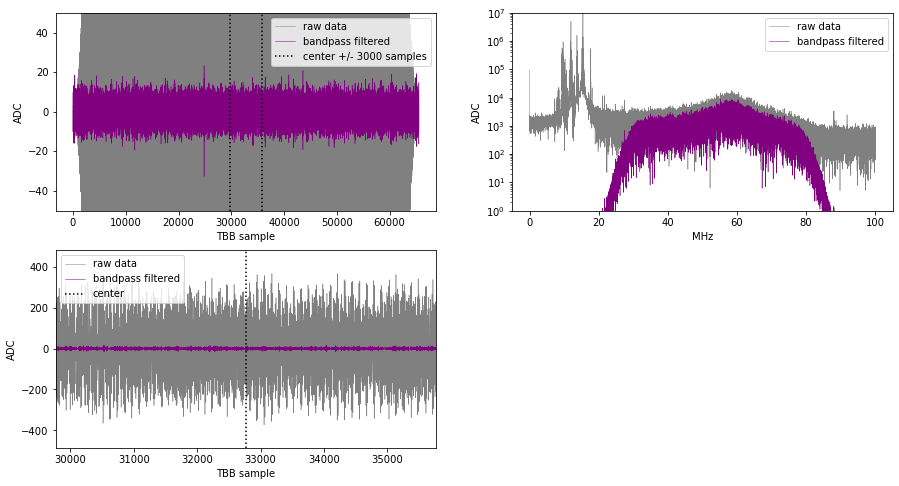

In [27]:
a=0

mid=2**16/2
freq=np.fft.rfftfreq(block_size, d=5e-9)*1e-6


fig=plt.figure(facecolor='white',figsize=(15,8))
ax1=fig.add_subplot(2,2,1)
ax2=fig.add_subplot(2,2,2)
ax3=fig.add_subplot(2,2,3)


ax1.plot(raw_data[a],color='grey',linewidth=0.5,label='raw data')
ax1.plot(filtered_data[a],color='purple',linewidth=0.5,label='bandpass filtered')
#ax1.plot(RFI_filtered_data[a],color='blue',linewidth=0.5,label='filtered+RFI removal')
ax1.set_xlabel('TBB sample',fontsize=10)
ax1.set_ylabel('ADC',fontsize=10)

ax2.plot(freq,raw_spectrum[a],color='grey',linewidth=0.5,label='raw data')
ax2.plot(freq,np.abs(np.fft.rfft(filtered_data[a])),color='purple',linewidth=0.5,label='bandpass filtered')
#ax2.plot(freq,cleaned_amplitude_spectrum[a],color='blue',linewidth=0.5,label='filtered+RFI removal')

ax3.plot(raw_data[a],color='grey',linewidth=0.5,label='raw data')
ax3.plot(filtered_data[a],color='purple',linewidth=0.5,label='bandpass filtered')
#ax3.plot(RFI_filtered_data[a],color='blue',linewidth=0.5,label='filtered+RFI removal')
ax3.set_xlabel('TBB sample',fontsize=10)
ax3.set_ylabel('ADC',fontsize=10)

ax2.set_yscale('log')
ax2.set_xlabel('MHz',fontsize=10)
ax2.set_ylabel('ADC',fontsize=10)
ax1.set_ylim([-50, 50])
ax2.set_ylim([1e0, 1e7])

ax3.set_xlim([mid-3000,mid+3000])

ax1.axvline(x=mid-3000, linestyle=':',color='black',label='center +/- 3000 samples')
ax1.axvline(x=mid+3000, linestyle=':',color='black')


ax3.axvline(x=32768, linestyle=':',color='black',label='center')

ax1.legend(loc="upper right", fontsize=10)
ax2.legend(loc="upper right", fontsize=10)
ax3.legend(loc="upper left", fontsize=10)



plt.show()


In [12]:
channel_ids = all_dipoles
nantennas=len(all_dipoles)

median_power = np.median(cleaned_power)
good_antennas = [channel_ids[i] for i in range(nantennas) if (0.5 * median_power < cleaned_power[i] < 2.0 * median_power)]
bad_antennas = [channel_ids[i] for i in range(nantennas) if (0.5 * median_power < cleaned_power[i] >= 2.0 * median_power)]

cabledelays=metadata.getCableDelays(station,TBB_data.antennaSet)
#note: what are these cable delays? They all fail the cr_physics.py test (567)

selected_dipoles = []
for i in range(int(len(all_dipoles) / 2)):
    if all_dipoles[2 * i] in good_antennas and all_dipoles[2 * i + 1] in good_antennas:# and cabledelays[2 * i] < 150.e-9 and cabledelays[2 * i + 1] < 150.e-9:
        selected_dipoles.extend([all_dipoles[2 * i], all_dipoles[2 * i + 1]])



# Do galaxy calibration 

This does both the normalization (part I still don't fully understand ??) and big calibration from ADC -> volts


In [13]:
calibrated_data=cal.calibrate(timestamp,filtered_data,cleaned_power,median_power)
calibrated_data_fft=np.fft.rfft(calibrated_data)

In [36]:
filtered_data

(96, 65536)

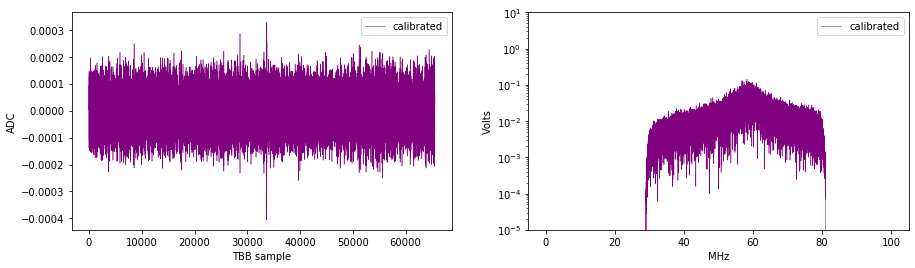

In [14]:
fig=plt.figure(facecolor='white',figsize=(15,4))
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)

ax1.plot(calibrated_data[a],color='purple',linewidth=0.5,label='calibrated')

ax1.set_xlabel('TBB sample',fontsize=10)
ax1.set_ylabel('ADC',fontsize=10)

ax2.plot(freq,np.abs(np.fft.rfft(calibrated_data[a])),color='purple',linewidth=0.5,label='calibrated')


ax2.set_yscale('log')
ax2.set_xlabel('MHz',fontsize=10)
ax2.set_ylabel('Volts',fontsize=10)
#ax1.set_ylim([-50, 50])
ax2.set_ylim([1e-5, 1e1])

ax1.legend(loc="upper right", fontsize=10)
ax2.legend(loc="upper right", fontsize=10)



plt.show()


# Correct for cable delays (sub-sample delays?)

This is currently not working- incorrect delay times?

In [143]:
#data=cal.do_phase_correction(calibrated_data,frequencies,cabledelays)

In [15]:
positions=TBB_data.get_LOFAR_centered_positions()

# Beamforming in LORA direction
To check if CR_found

In [16]:
imp.reload(beamformer)

<module 'beamformer' from '/vol/astro7/lofar/kmulrey/test_pipeline/scripts/beamformer.py'>

In [17]:
print(lora_direction)

(304.2, 44.75)


In [37]:
print (sys.getsizeof(timeseries_data)/(1024*1024),"MB")
print ("shape of timeseries_data",timeseries_data.shape)

48.00010681152344 MB
shape of timeseries_data (96, 65536)


In [18]:
timeseries_data=calibrated_data  # just renaming it
beamformed_timeseries_0,beamformed_timeseries_1=beamformer.return_minibeamformed_data(timeseries_data,positions,lora_direction)

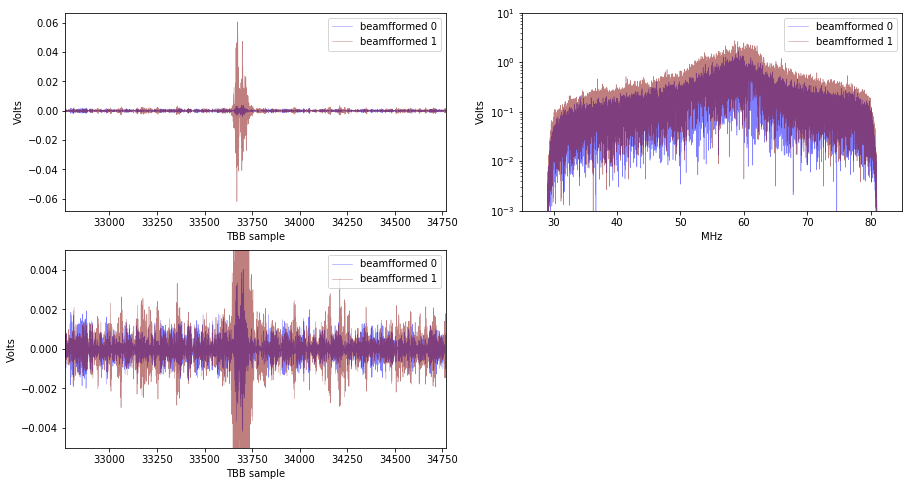

In [19]:
fig=plt.figure(facecolor='white',figsize=(15,8))
ax1=fig.add_subplot(2,2,1)
ax2=fig.add_subplot(2,2,2)
ax3=fig.add_subplot(2,2,3)

ax1.plot(beamformed_timeseries_0,color='blue',linewidth=0.5,alpha=0.5,label='beamfformed 0')
ax1.plot(beamformed_timeseries_1,color='maroon',linewidth=0.5,alpha=0.5,label='beamfformed 1')

ax1.set_xlabel('TBB sample',fontsize=10)
ax1.set_ylabel('Volts',fontsize=10)

ax2.plot(freq,np.abs(np.fft.rfft(beamformed_timeseries_0)),color='blue',linewidth=0.5,alpha=0.5,label='beamfformed 0')
ax2.plot(freq,np.abs(np.fft.rfft(beamformed_timeseries_1)),color='maroon',linewidth=0.5,alpha=0.5,label='beamfformed 1')


ax2.set_yscale('log')
ax2.set_xlabel('MHz',fontsize=10)
ax2.set_ylabel('Volts',fontsize=10)
#ax1.set_ylim([-50, 50])
ax2.set_ylim([1e-3, 1e1])
ax1.set_xlim([mid,mid+2000])


ax3.plot(beamformed_timeseries_0,color='blue',linewidth=0.5,alpha=0.5,label='beamfformed 0')
ax3.plot(beamformed_timeseries_1,color='maroon',linewidth=0.5,alpha=0.5,label='beamfformed 1')

ax3.set_xlabel('TBB sample',fontsize=10)
ax3.set_ylabel('Volts',fontsize=10)
ax3.set_xlim([mid,mid+2000])
ax3.set_ylim([-0.005,0.005])
ax2.set_xlim([25,85])


ax1.legend(loc="upper right", fontsize=10)
ax2.legend(loc="upper right", fontsize=10)
ax3.legend(loc="upper right", fontsize=10)



plt.show()

# Look for significant pulse in beamformed signal

Using pulse envelope, Hilbert transform



In [20]:
search_window_start=int(mid-1000)  # i made up the window size
search_window_end=int(mid+3000)

noise_window_start=int(0)
noise_window_end=int(mid-5000)
good_signal=3 # pick acceptable snr
min_number_good_antennas=3
window=500

In [150]:
analytic_signal_0 = hilbert(beamformed_timeseries_0)
analytic_signal_1 = hilbert(beamformed_timeseries_1)

amplitude_envelope_0 = np.abs(analytic_signal_0)
amplitude_envelope_1 = np.abs(analytic_signal_1)



In [151]:
# find dominant polarization
peak0=np.max(amplitude_envelope_0)
peak1=np.max(amplitude_envelope_1)

if peak0>peak1:
    dominant_pol=0
else: 
    dominant_pol=1
print('dominant_polarization =',dominant_pol)

dominant_polarization = 1


In [152]:
if dominant_pol==0:
    signal_window_start=int(np.argmax(amplitude_envelope_0)-window/2)  # i made up the window size
    signal_window_end=int(np.argmax(amplitude_envelope_0)+window/2)
else:
    signal_window_start=int(np.argmax(amplitude_envelope_1)-window/2)  # i made up the window size
    signal_window_end=int(np.argmax(amplitude_envelope_1)+window/2)


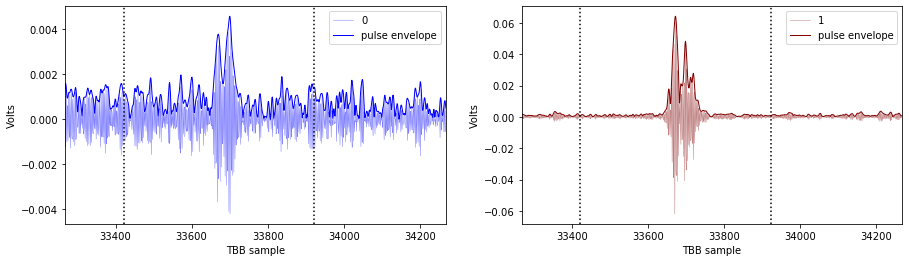

In [153]:
fig=plt.figure(facecolor='white',figsize=(15,4))
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)

ax1.plot(beamformed_timeseries_0,color='blue',linewidth=0.5,alpha=0.5,label='0')
ax1.plot(amplitude_envelope_0,color='blue',linewidth=1,label='pulse envelope')


ax2.plot(beamformed_timeseries_1,color='maroon',linewidth=0.5,alpha=0.5,label='1')
ax2.plot(amplitude_envelope_1,color='maroon',linewidth=1,label='pulse envelope')

ax1.set_xlabel('TBB sample',fontsize=10)
ax1.set_ylabel('Volts',fontsize=10)

ax2.set_xlabel('TBB sample',fontsize=10)
ax2.set_ylabel('Volts',fontsize=10)

ax1.set_xlim([mid+500,mid+1500])
ax2.set_xlim([mid+500,mid+1500])
ax1.axvline(x=signal_window_start, linestyle=':',color='black')
ax1.axvline(x=signal_window_end, linestyle=':',color='black')
ax2.axvline(x=signal_window_start, linestyle=':',color='black')
ax2.axvline(x=signal_window_end, linestyle=':',color='black')

ax1.axvspan(noise_window_start, noise_window_end, alpha=0.25, color='grey')
ax2.axvspan(noise_window_start, noise_window_end, alpha=0.25, color='grey')


ax1.legend(loc="upper right", fontsize=10)
ax2.legend(loc="upper right", fontsize=10)



plt.show()

In [154]:
peak0=np.max(amplitude_envelope_0)
peak1=np.max(amplitude_envelope_1)

if peak0>peak1:
    dominant_pol=0
else: 
    dominant_pol=1
print('dominant_polarization =',dominant_pol)

dominant_polarization = 1


In [155]:
rms_0=np.sqrt(np.mean((amplitude_envelope_0[noise_window_start:noise_window_end])**2))
rms_1=np.sqrt(np.mean((amplitude_envelope_1[noise_window_start:noise_window_end])**2))
peak_0=np.max(amplitude_envelope_0[signal_window_start:signal_window_end])
peak_1=np.max(amplitude_envelope_1[signal_window_start:signal_window_end])
snr_0=peak_0/rms_0
snr_1=peak_1/rms_1

max_sample_0=np.argmax(amplitude_envelope_0[signal_window_start:signal_window_end])
max_sample_1=np.argmax(amplitude_envelope_1[signal_window_start:signal_window_end])


In [156]:
if snr_0>=good_signal or snr_1>=good_signal:
    print('found CR with beamforming')
    
# if no CR found, exit station loop

found CR with beamforming


# Find number antennas with a good signal

In [157]:
timeseries_0=timeseries_data[::2]
timeseries_1=timeseries_data[1::2]

single_analytic_signal_0 = hilbert(timeseries_0)
single_analytic_signal_1 = hilbert(timeseries_1)

single_amplitude_envelope_0 = np.abs(single_analytic_signal_0)
single_amplitude_envelope_1 = np.abs(single_analytic_signal_1)

    

In [158]:
rms_all=np.zeros([2,len(timeseries_0)])
peak_all=np.zeros([2,len(timeseries_0)])
snr_all=np.zeros([2,len(timeseries_0)])
good_dipoles=0

for i in np.arange(len(timeseries_0)):
    rms0=np.sqrt(np.mean((single_amplitude_envelope_0[i][noise_window_start:noise_window_end])**2))
    rms1=np.sqrt(np.mean((single_amplitude_envelope_1[i][noise_window_start:noise_window_end])**2))
    peak0=np.max(single_amplitude_envelope_0[i][signal_window_start:signal_window_end])
    peak1=np.max(single_amplitude_envelope_1[i][signal_window_start:signal_window_end])
    snr0=peak0/rms0
    snr1=peak1/rms1
    
    if snr0>=good_signal or snr1>=good_signal:
        good_dipoles=good_dipoles+1
    
print('n good anntennas: {0}'.format(good_dipoles))

if good_dipoles>=min_number_good_antennas:
    print('passed minimum number of good antennas')
    
#if fewer than min_number_good_antennas found, exit station loop

n good anntennas: 46
passed minimum number of good antennas


<ipython-input-158-ce5d0009ec74>:11: RuntimeWarning: invalid value encountered in double_scalars
  snr0=peak0/rms0
<ipython-input-158-ce5d0009ec74>:12: RuntimeWarning: invalid value encountered in double_scalars
  snr1=peak1/rms1


# Unfold antenna response
The first iteration is in direction from LORA

In [159]:
imp.reload(antenna_model)

<module 'antenna_model' from '/vol/astro7/lofar/kmulrey/test_pipeline/scripts/antenna_model.py'>

In [160]:
onsky_0,onsky_1=antenna_model.unfold_model(timeseries_0,timeseries_1,pulse_direction)

In [161]:
#even_pol_FFT = np.fft.rfft(timeseries_0)
##odd_pol_FFT =  np.fft.rfft(timeseries_1)
#frequencies_AM = np.fft.rfftfreq(block_size, d=5e-9)

#fft_onsky_0,fft_onsky_1=antenna_model.return_unfolded_traces(even_pol_FFT,odd_pol_FFT,pulse_direction,frequencies_AM)
#onsky_0=np.fft.irfft(fft_onsky_0)
#onsky_1=np.fft.irfft(fft_onsky_1)


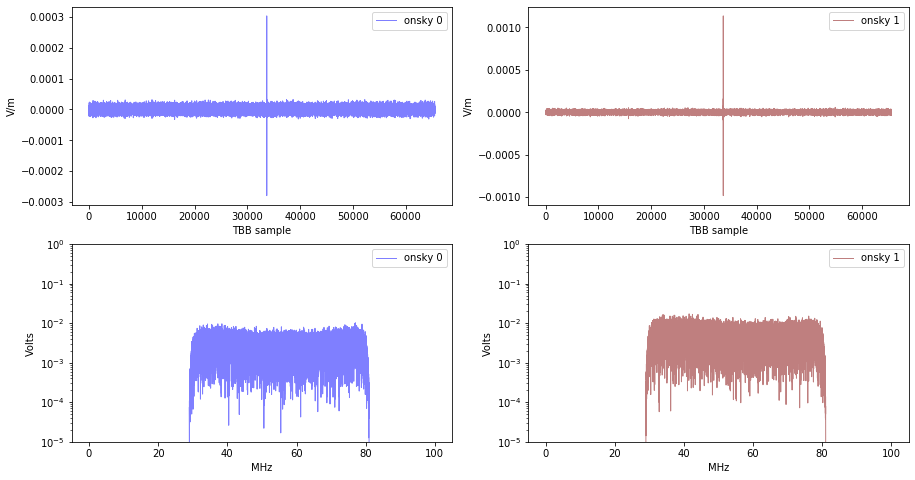

In [163]:
a=0
fig=plt.figure(facecolor='white',figsize=(15,8))
ax1=fig.add_subplot(2,2,1)
ax2=fig.add_subplot(2,2,2)
ax3=fig.add_subplot(2,2,3)
ax4=fig.add_subplot(2,2,4)

ax1.plot(onsky_0[a],color='blue',linewidth=1.0,alpha=0.5,label='onsky 0')
ax2.plot(onsky_1[a],color='maroon',linewidth=1.0,alpha=0.5,label='onsky 1')

ax3.plot(freq,np.abs(np.fft.rfft(onsky_0[a])),color='blue',linewidth=1.0,alpha=0.5,label='onsky 0')
ax4.plot(freq,np.abs(np.fft.rfft(onsky_1[a])),color='maroon',linewidth=1.0,alpha=0.5,label='onsky 1')


ax1.set_xlabel('TBB sample',fontsize=10)
ax1.set_ylabel('V/m',fontsize=10)

ax2.set_xlabel('TBB sample',fontsize=10)
ax2.set_ylabel('V/m',fontsize=10)


##ax1.set_xlim([30000,33000])
#ax2.set_xlim([30000,33000])


ax3.set_yscale('log')
ax3.set_xlabel('MHz',fontsize=10)
ax3.set_ylabel('Volts',fontsize=10)
ax4.set_yscale('log')
ax4.set_xlabel('MHz',fontsize=10)
ax4.set_ylabel('Volts',fontsize=10)

ax1.legend(loc="upper right", fontsize=10)
ax2.legend(loc="upper right", fontsize=10)
ax3.legend(loc="upper right", fontsize=10)
ax4.legend(loc="upper right", fontsize=10)

ax3.set_ylim([1e-5, 1e-0])
ax4.set_ylim([1e-5, 1e-0])


plt.show()

# Start direction fitting loop 
(798) "DirectionFitBF"

1. unfold antenna response
2. direction fit
3. pulse envelope
4. find integrated power
5. pulse envelope -> delays
6. DirectionFitPlaneWave -> update pulse direction 

repeat until difference in pulse direction between iterations converges to <0.5 degrees

In [164]:
positions_0=positions[::2]
positions_1=positions[1::2]

In [179]:
imp.reload(beamformer)

<module 'beamformer' from '/vol/astro7/lofar/kmulrey/test_pipeline/scripts/beamformer.py'>

In [180]:
new_pulse_direction=(pulse_direction)#pulse_direction
old_pulse_direction=(0.0,0.0)
maxiter=30

direction_difference=np.asarray([100,100])
fft_onsky_0=np.fft.rfft(onsky_0)
fft_onsky_1=np.fft.rfft(onsky_1)


while (direction_difference[0]>1 and direction_difference[1]>1):
    old_pulse_direction=new_pulse_direction
    print('old: ',old_pulse_direction)
    # not really necessary to do the fit in both polarizations?
    direction_fit_1, timeseries1 = beamformer.directionFitBF(fft_onsky_1,frequencies,positions_1,new_pulse_direction,maxiter)
    direction_fit_0, timeseries0 = beamformer.directionFitBF(fft_onsky_0,frequencies,positions_0,new_pulse_direction,maxiter)
    if dominant_pol==0:
        new_pulse_direction=direction_fit_0
    else: 
        new_pulse_direction=direction_fit_1
    
    direction_difference=np.abs(np.asarray([old_pulse_direction[0]-new_pulse_direction[0],old_pulse_direction[1]-new_pulse_direction[1]]))
    
print('Fitting converged on  {0:.2f}, {1:.2f}'.format(new_pulse_direction[0],new_pulse_direction[1]))

old:  (304.2, 44.75)
Optimization terminated successfully.
         Current function value: -0.000184
         Iterations: 3
         Function evaluations: 42
Optimization terminated successfully.
         Current function value: -0.000001
         Iterations: 4
         Function evaluations: 59
old:  [318.68123346  51.83200426]
Optimization terminated successfully.
         Current function value: -0.000184
         Iterations: 1
         Function evaluations: 16
Optimization terminated successfully.
         Current function value: -0.000001
         Iterations: 4
         Function evaluations: 60
Fitting converged on  318.68, 51.83


In [167]:
analytic_signal_0 = hilbert(timeseries0)
analytic_signal_1 = hilbert(timeseries1)

amplitude_envelope_0 = np.abs(analytic_signal_0)
amplitude_envelope_1 = np.abs(analytic_signal_1)

In [168]:
# find dominant polarization
peak0=np.max(amplitude_envelope_0)
peak1=np.max(amplitude_envelope_1)

if peak0>peak1:
    dominant_pol=0
    peak_pos=np.argmax(amplitude_envelope_0)
else: 
    dominant_pol=1
    peak_pos=np.argmax(amplitude_envelope_1)

print('dominant_polarization =',dominant_pol)

dominant_polarization = 1


In [169]:
print(amplitude_envelope_0.shape)
print(peak_pos)
print(2**16)

(65536,)
33678
65536


# do plane wave fitting to find new direction
using pulse envelope

signal_window: 1500 -> 2500
noise_window: 0 -> 27768
time delay:  0.0001683934375


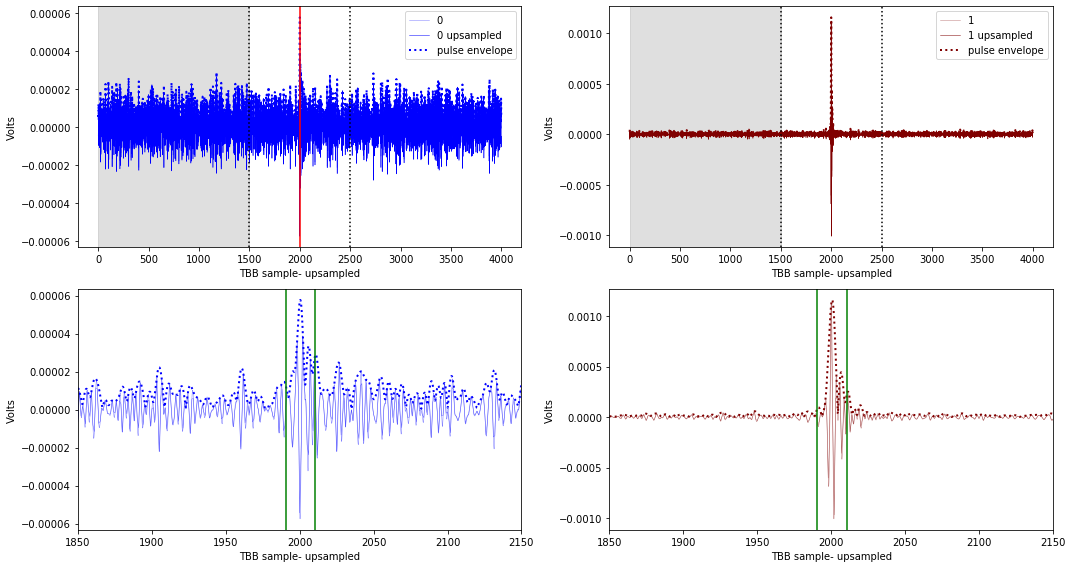

time delay:  0.00016838625


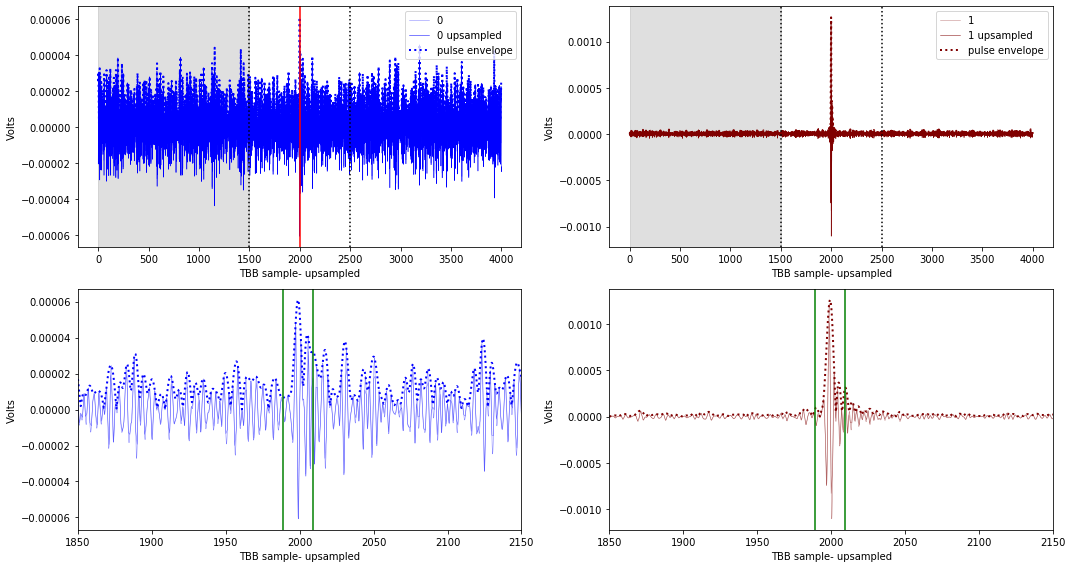

time delay:  0.000168389375


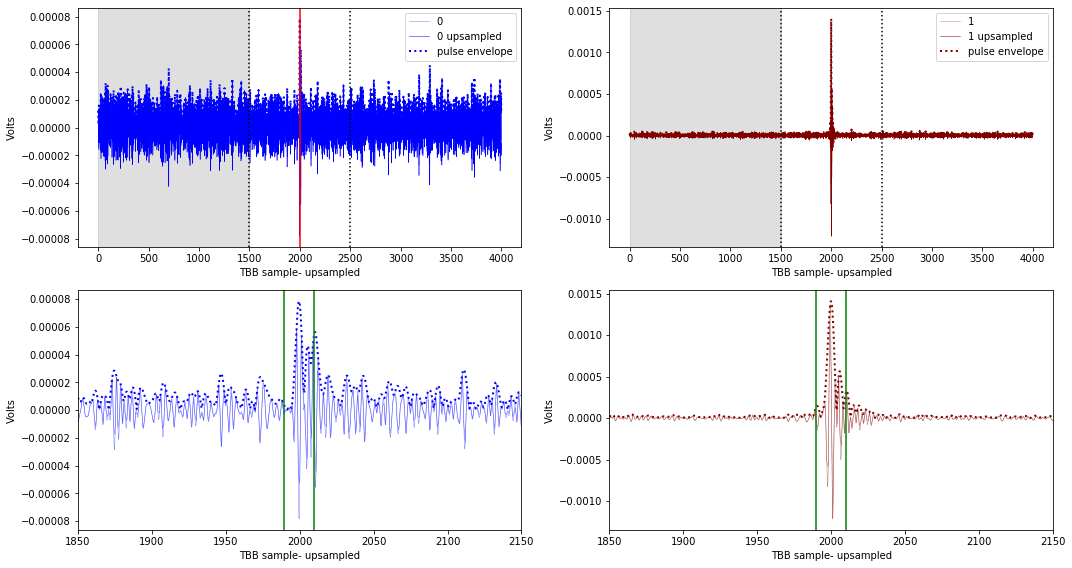

time delay:  0.00016842125


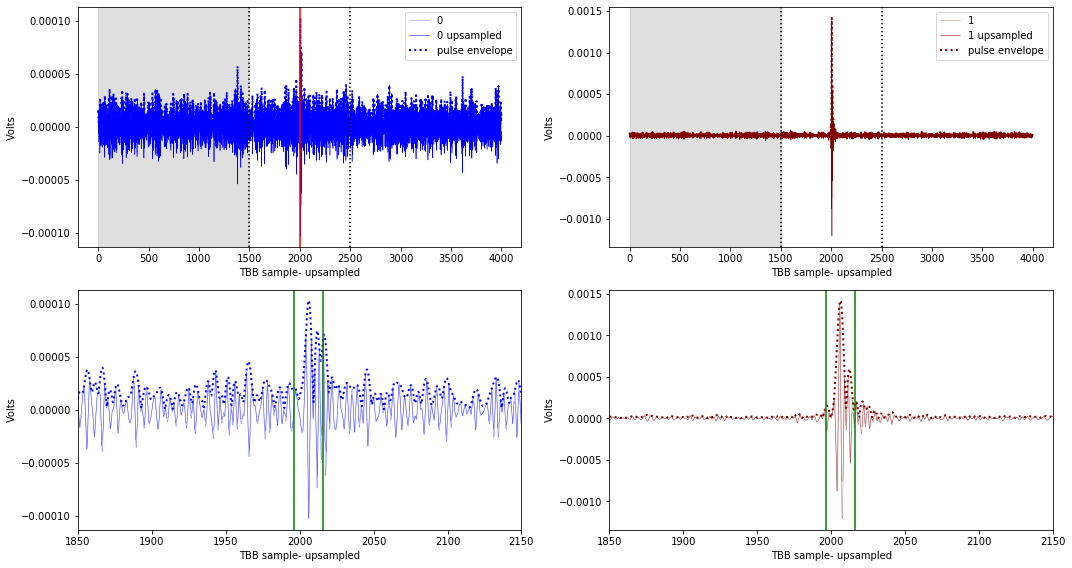

time delay:  0.0001684265625


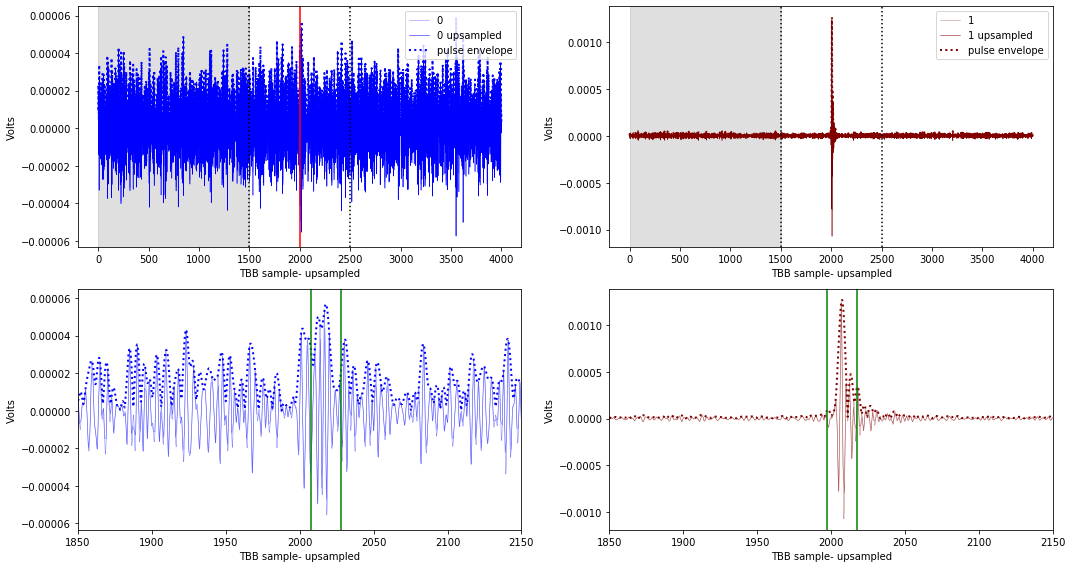

time delay:  0.0001684546875


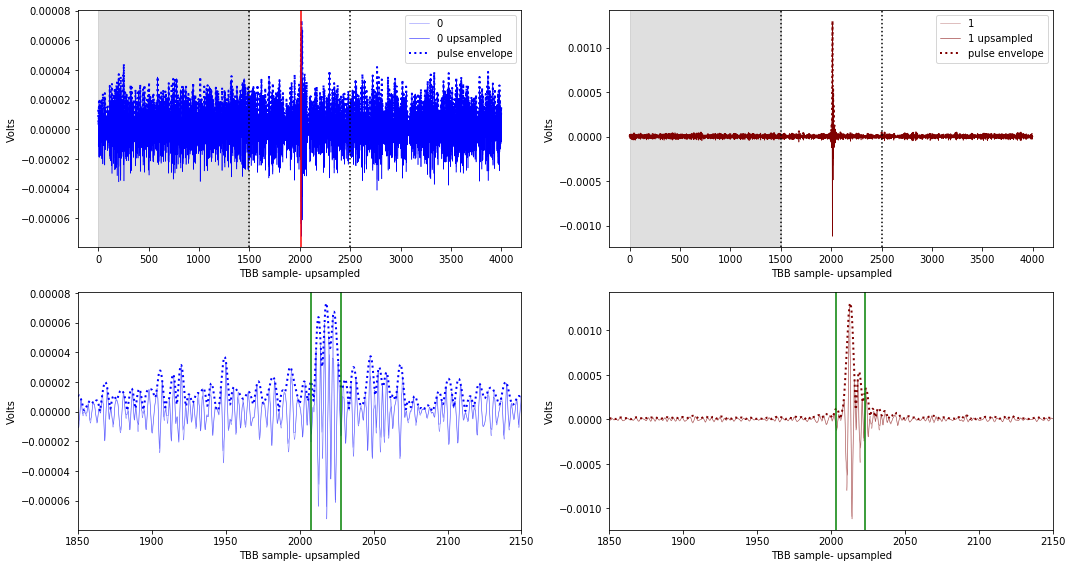

time delay:  0.00016847531250000001


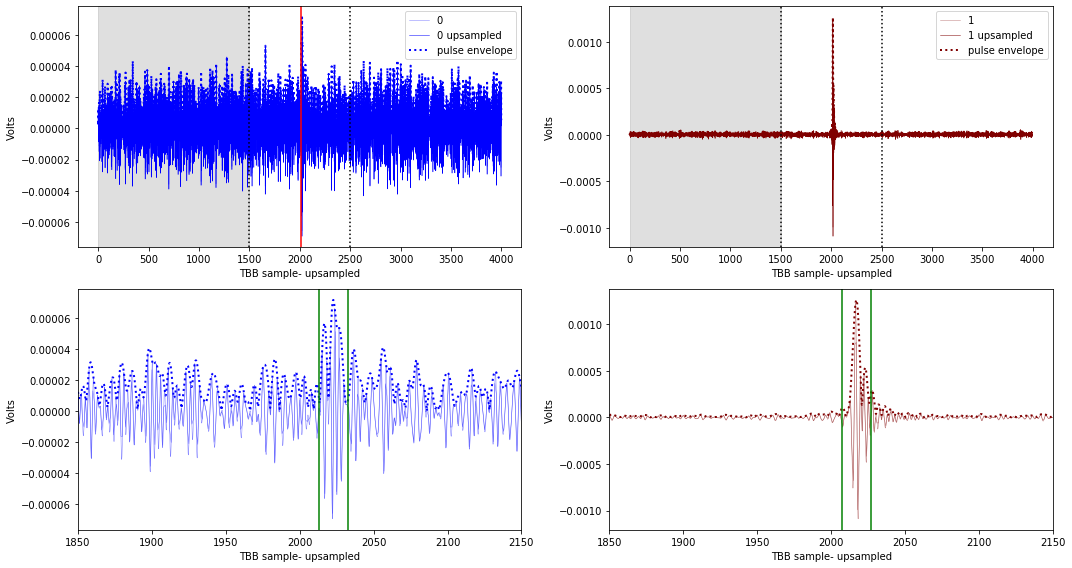

time delay:  0.000168485625


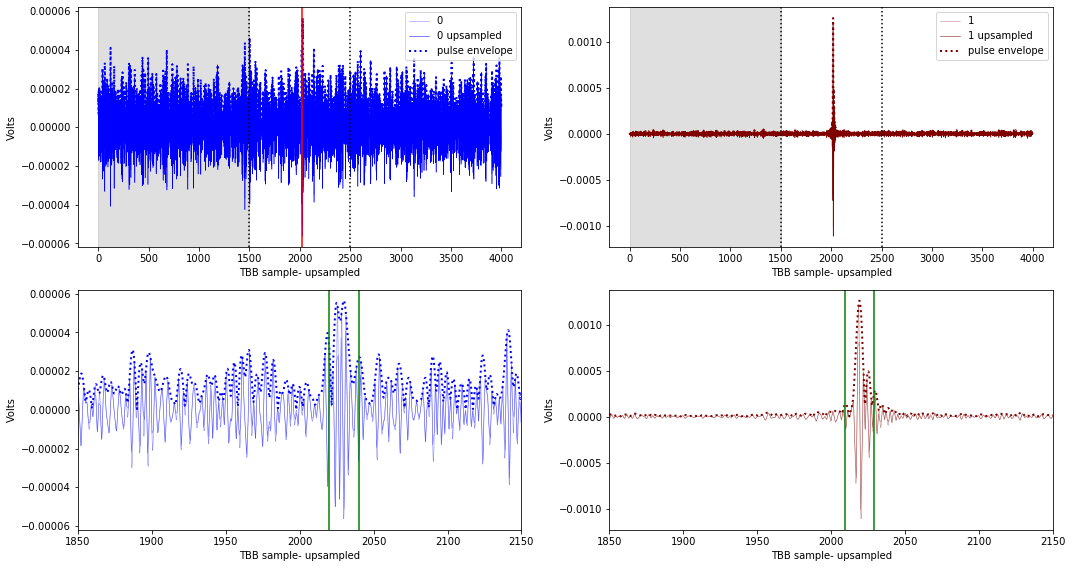

time delay:  0.000168461875


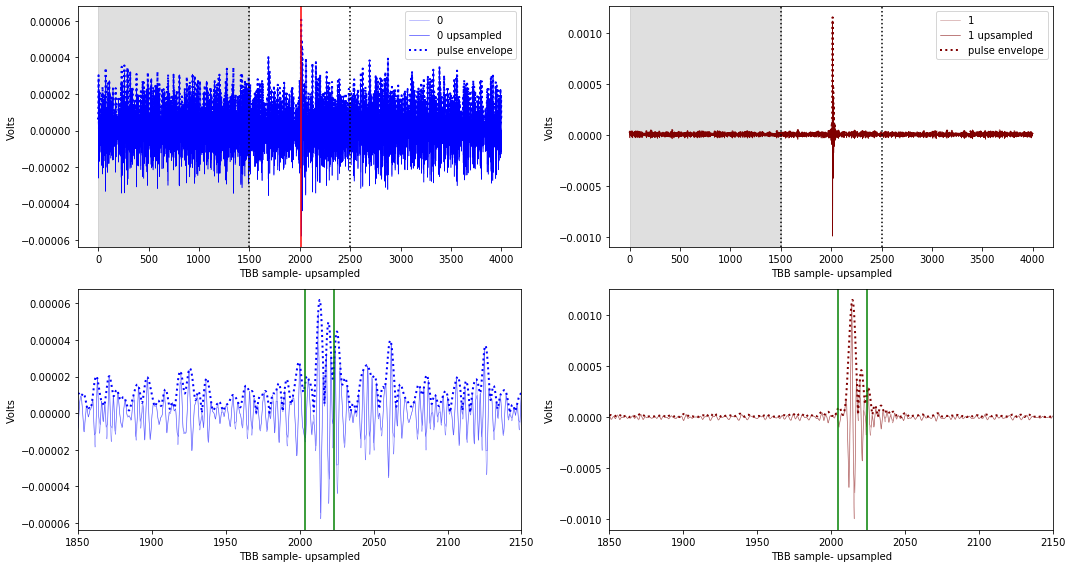

time delay:  0.0001684534375


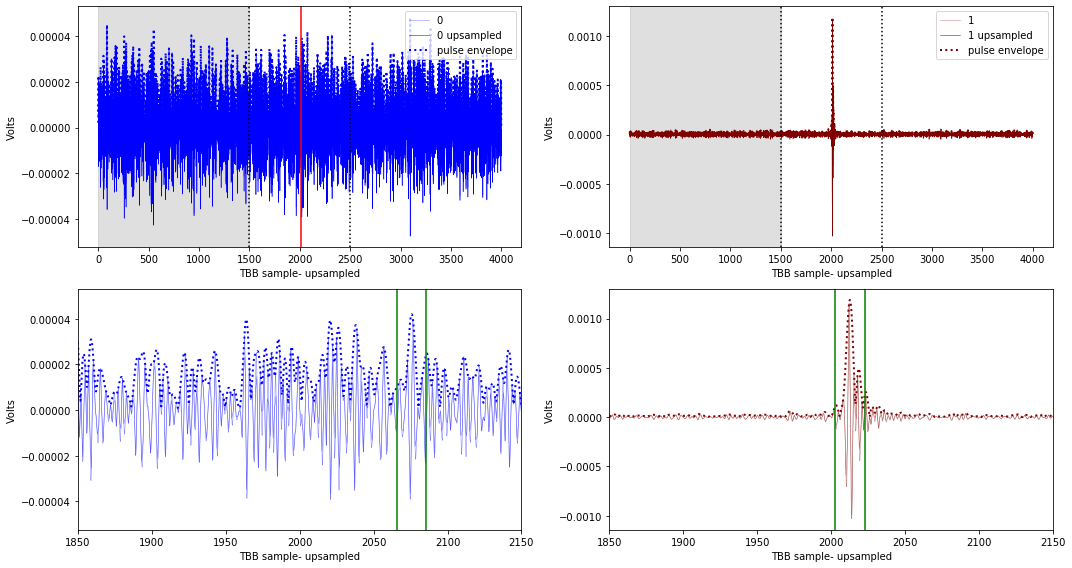

time delay:  0.0001684271875


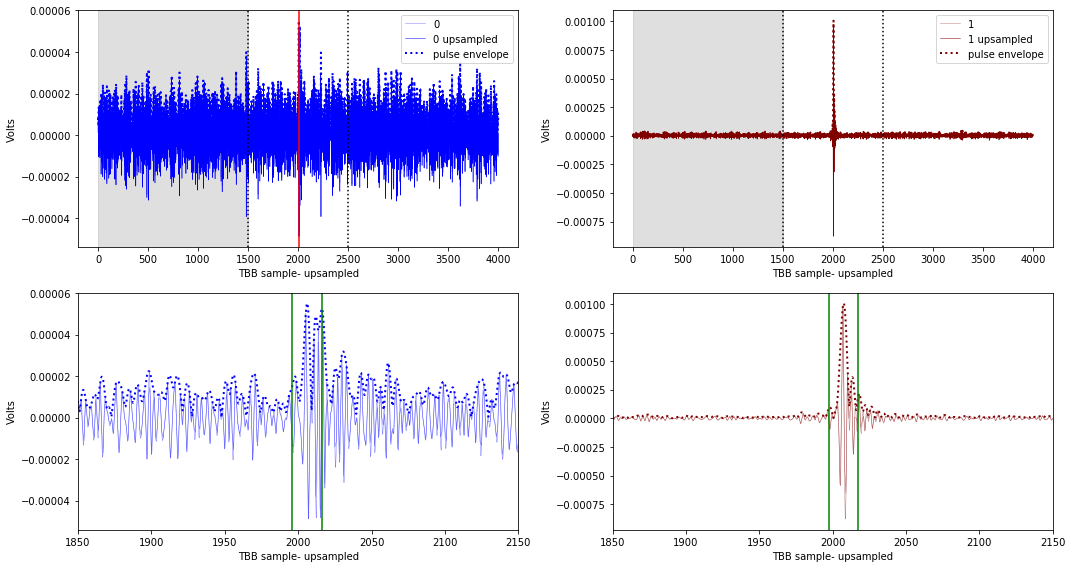

time delay:  0.00016841


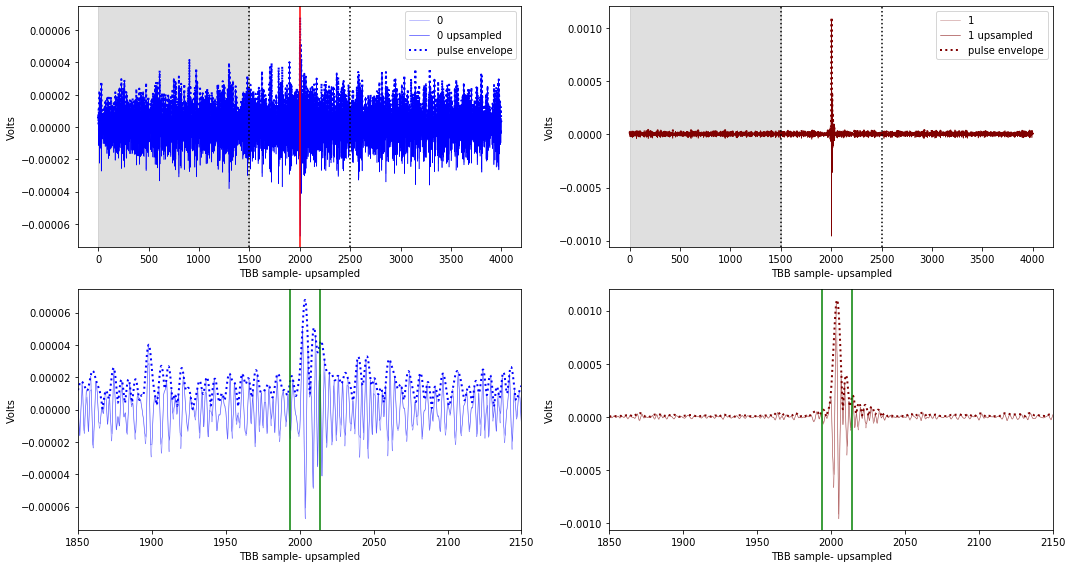

time delay:  0.0001683878125


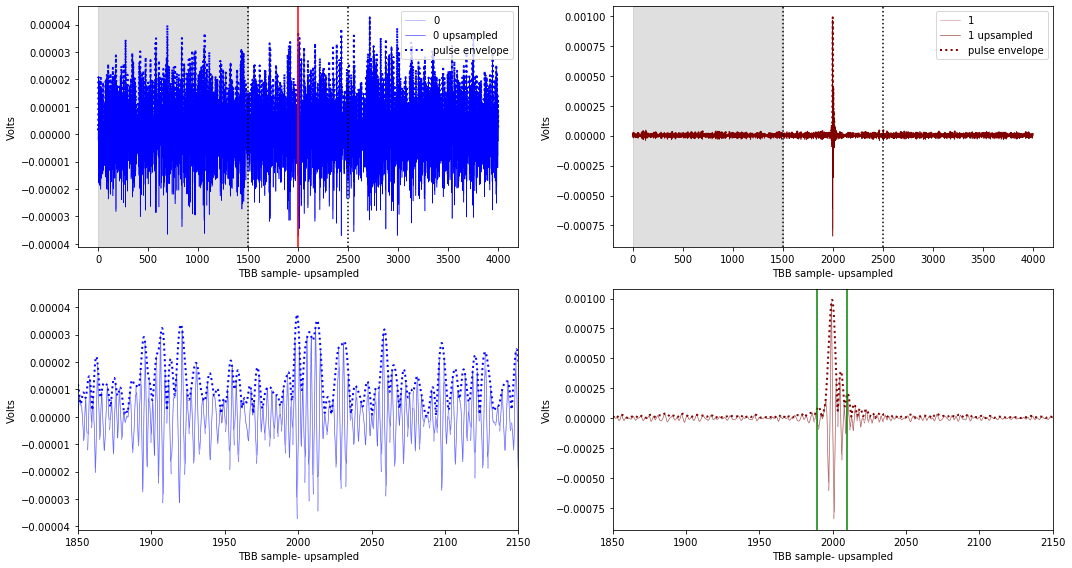

time delay:  0.000168375625


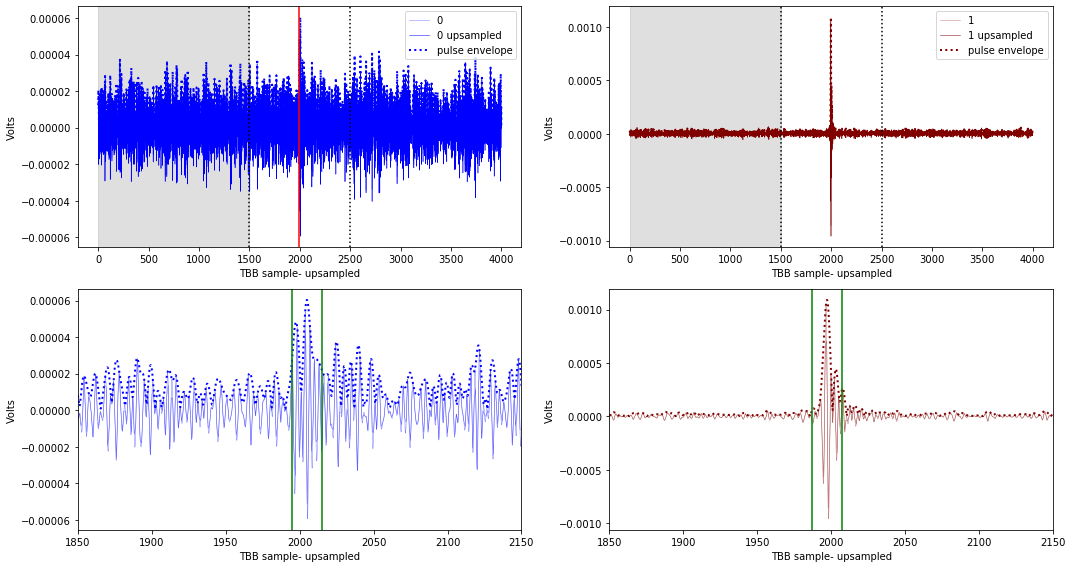

time delay:  0.000168368125


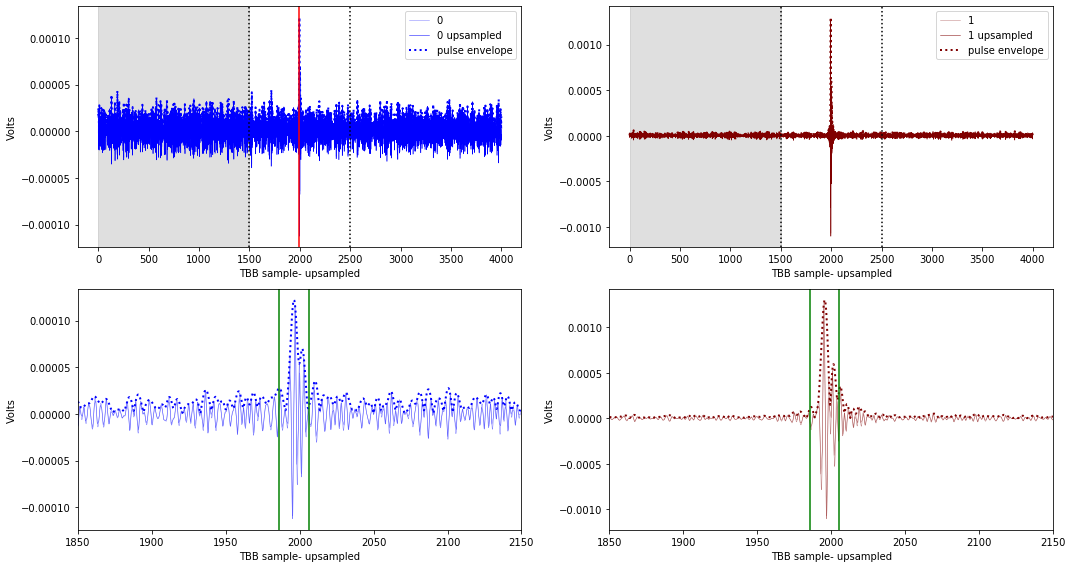

time delay:  0.0001683825


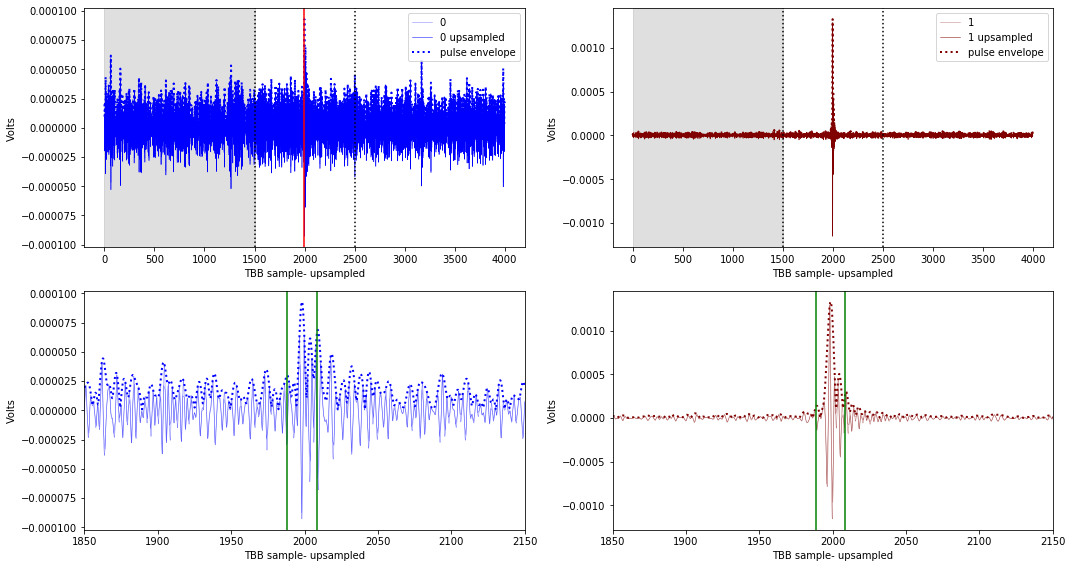

time delay:  0.0001684125


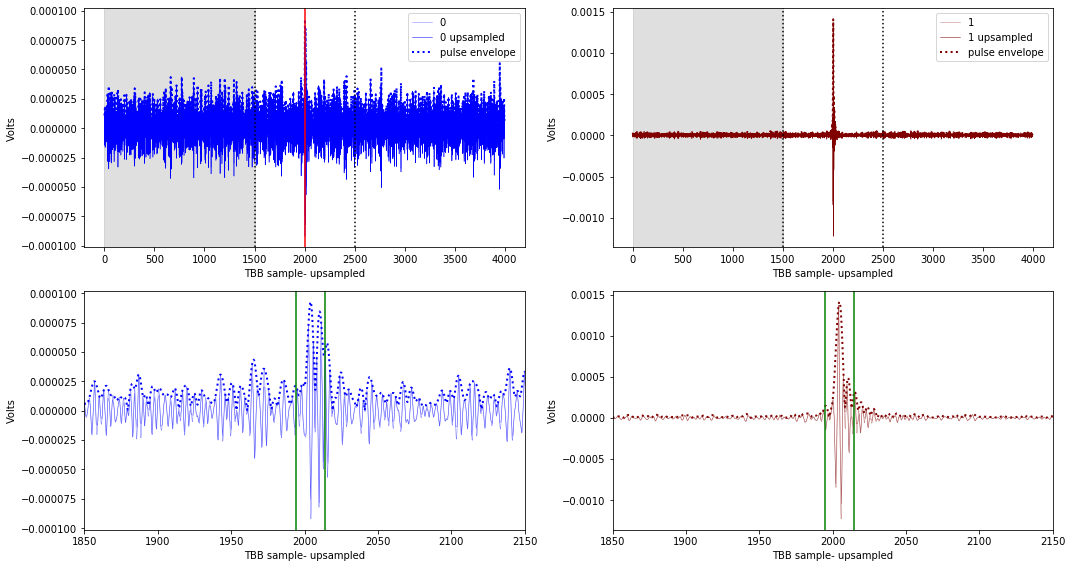

time delay:  0.0001684309375


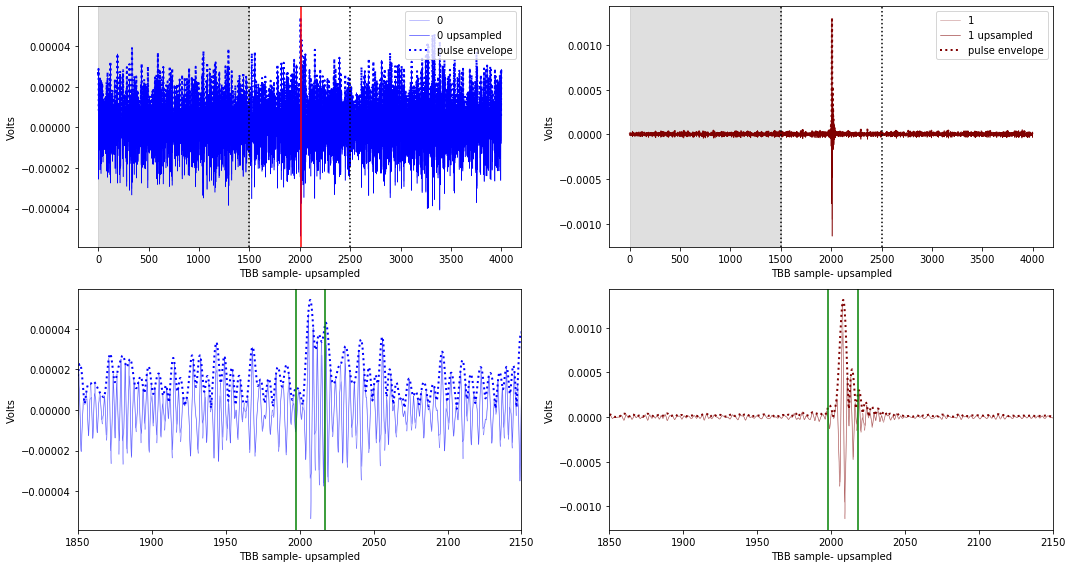

time delay:  0.00016846375


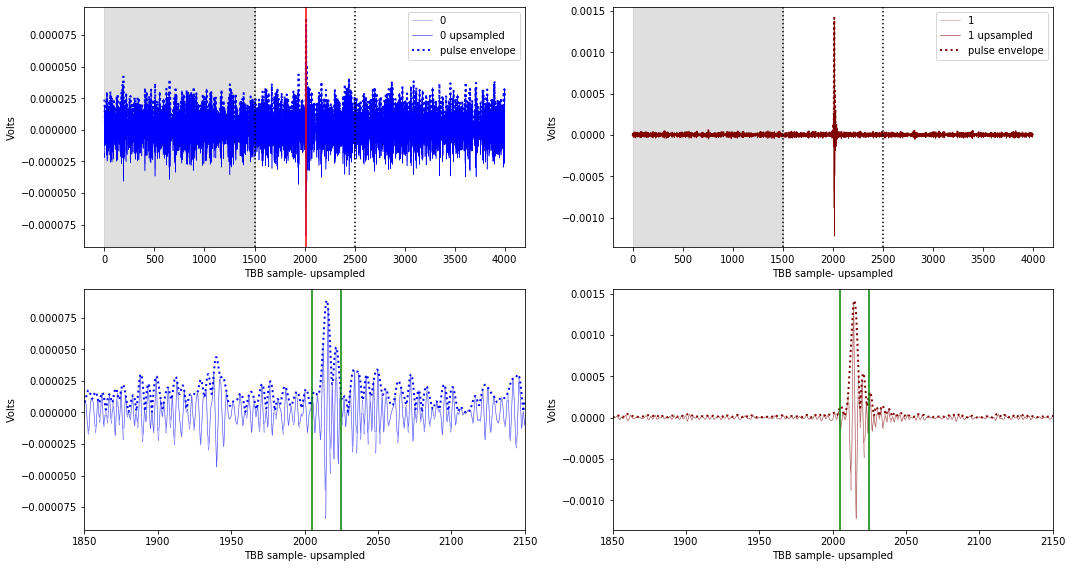

time delay:  0.0001684878125


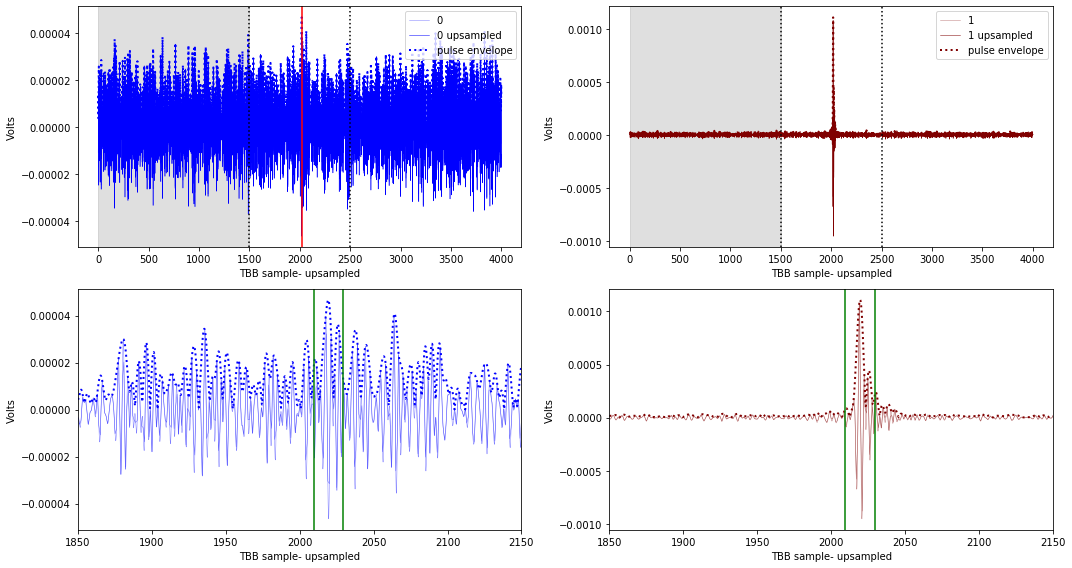

time delay:  0.0001684975


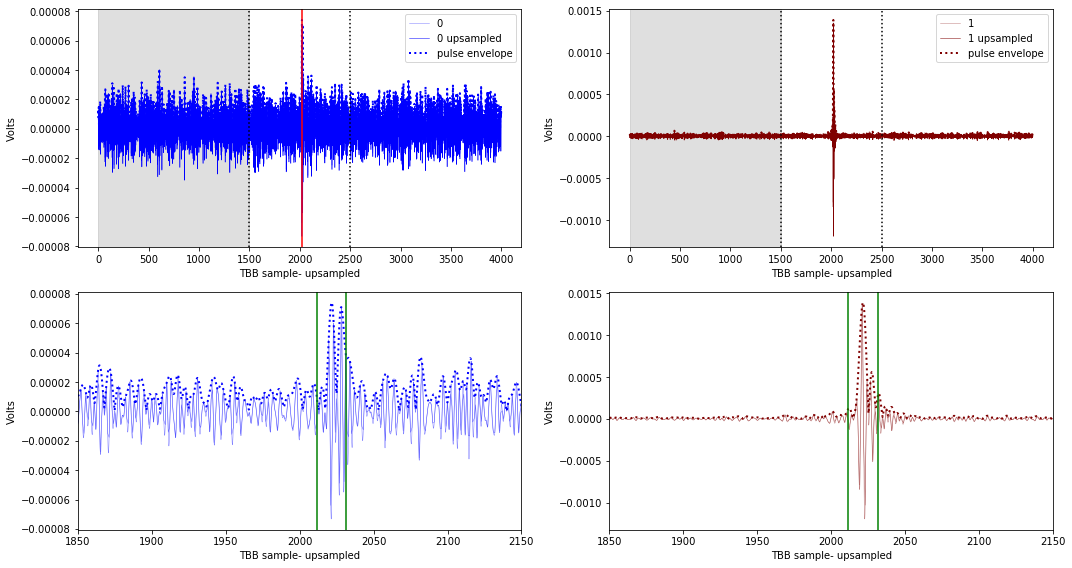

time delay:  0.000168495


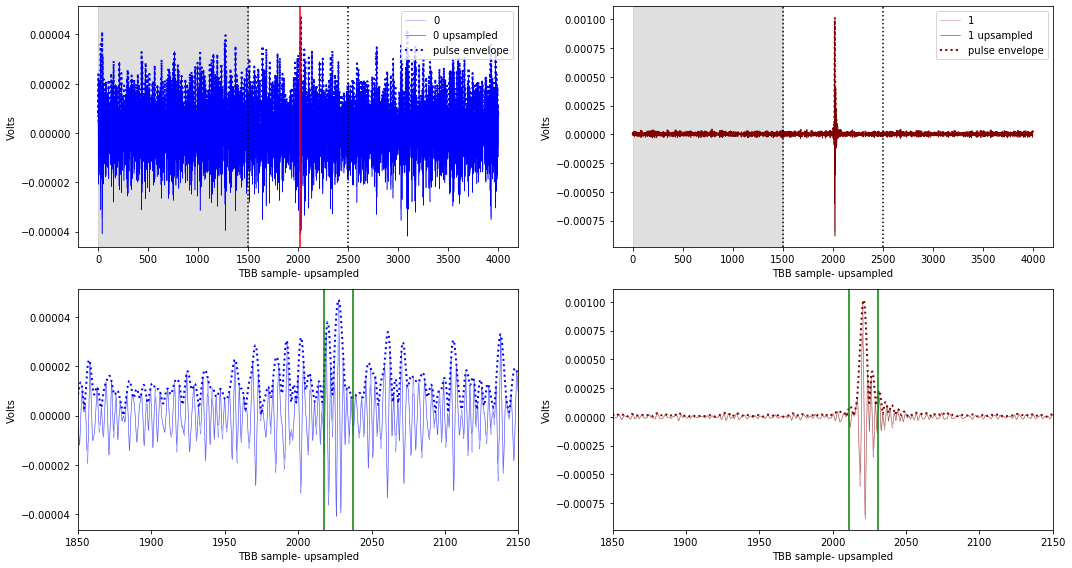

time delay:  0.000168478125


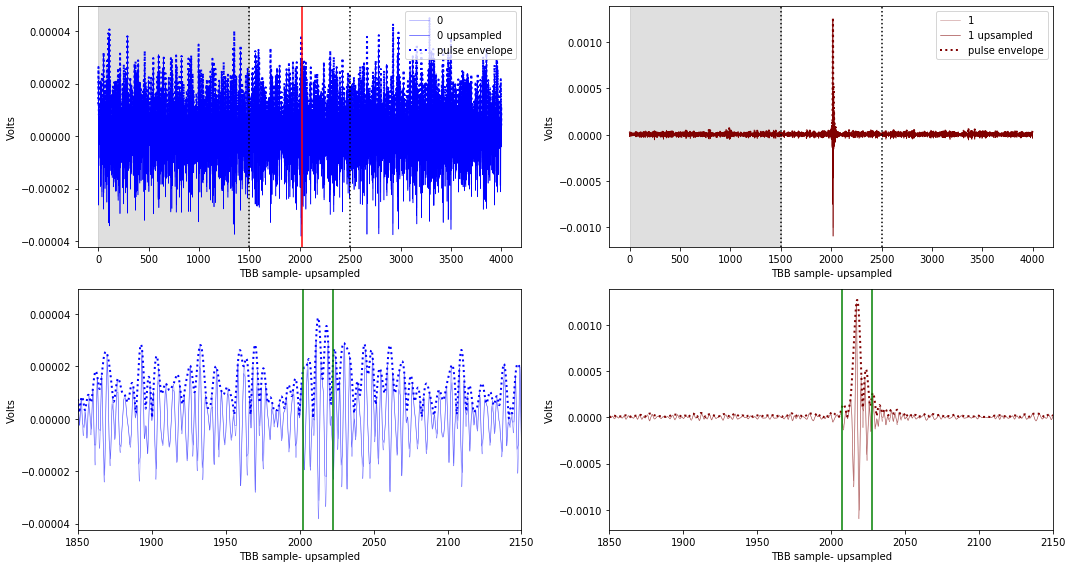

time delay:  0.0001684390625


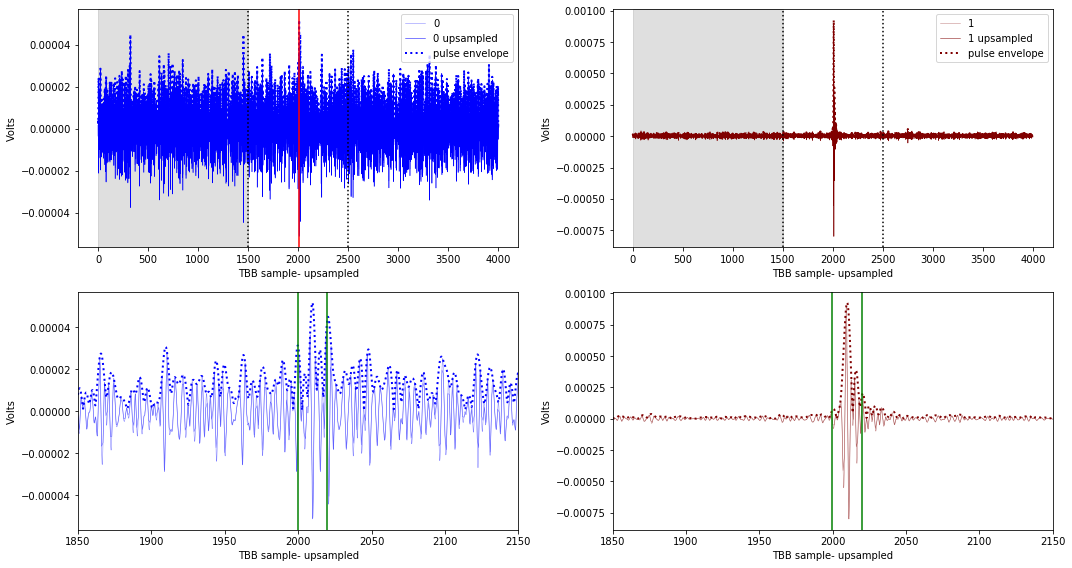

time delay:  0.0001684028125


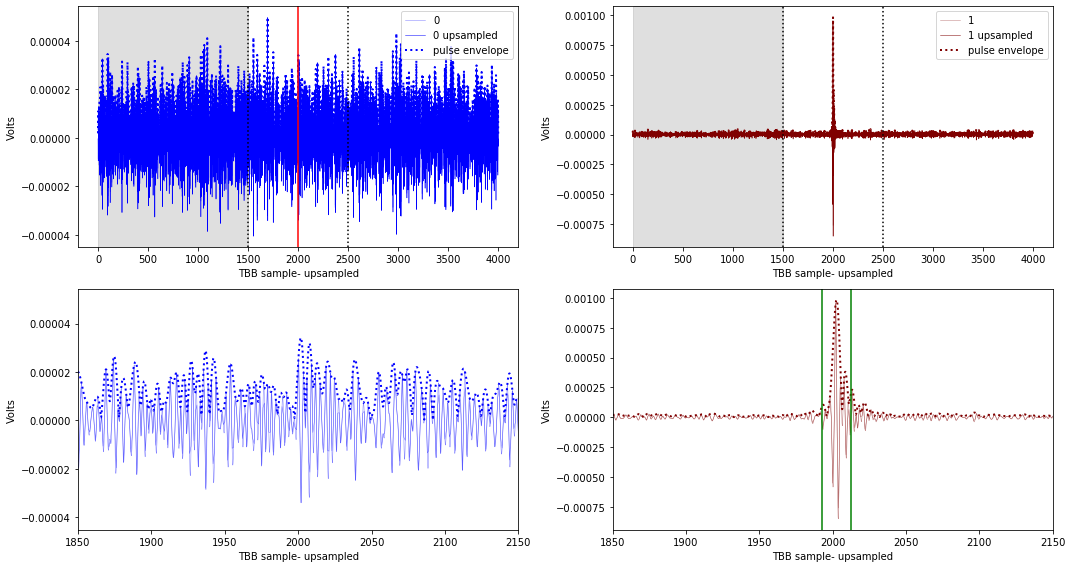

time delay:  0.000168378125


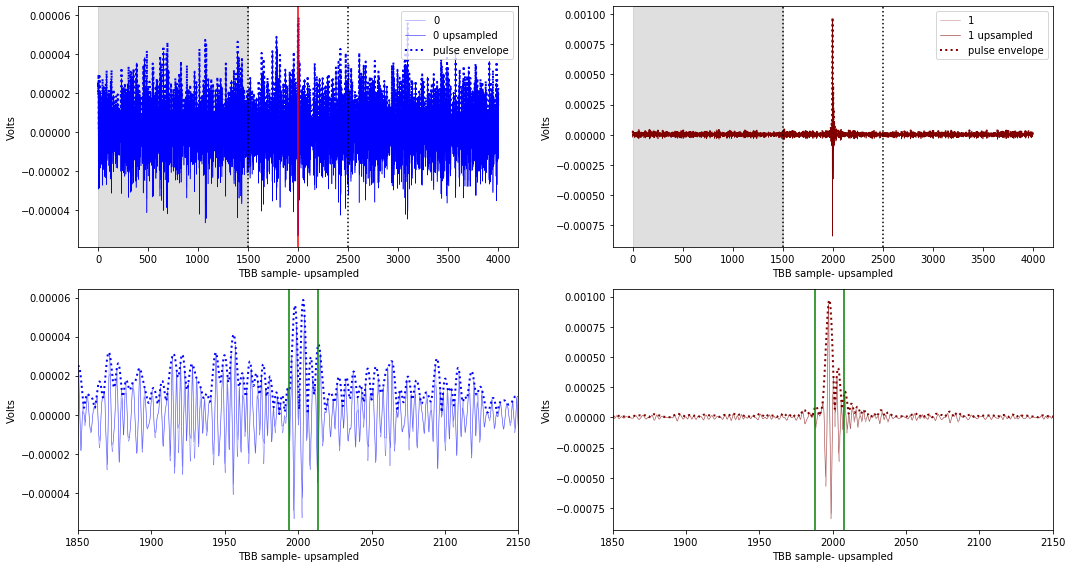

time delay:  0.0001683578125


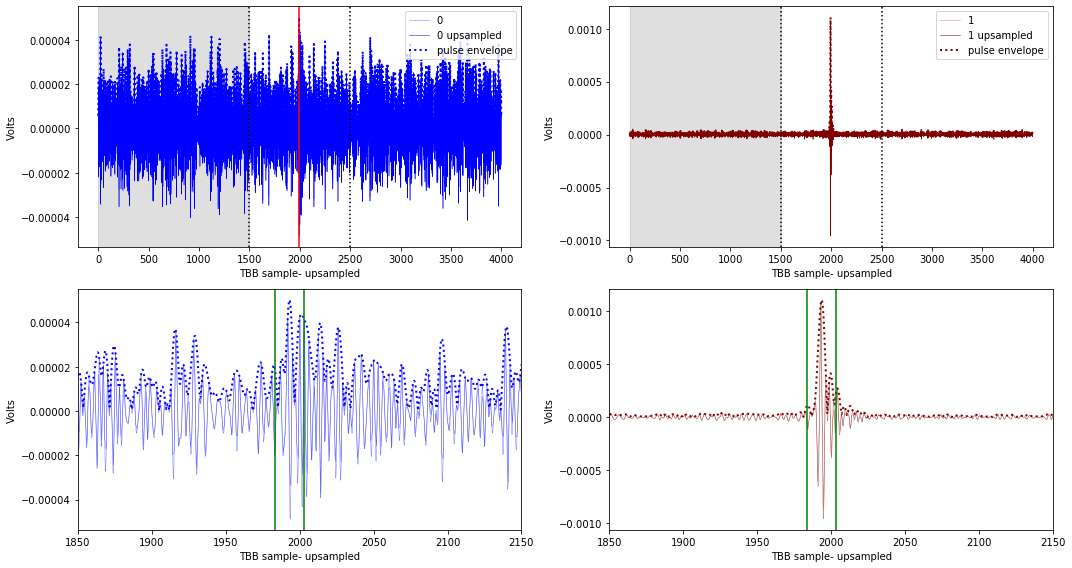

time delay:  0.0001683571875


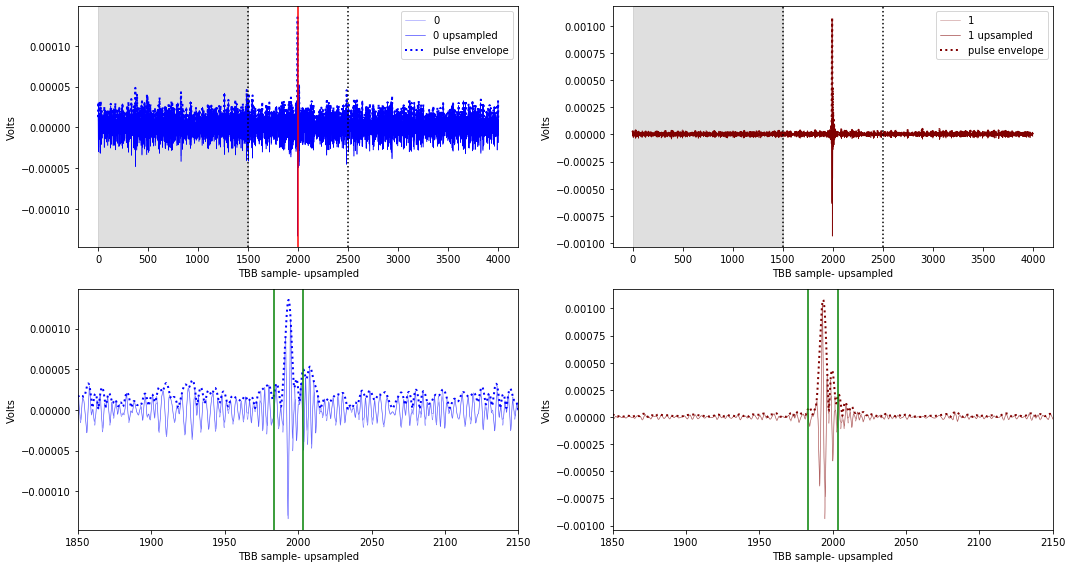

time delay:  0.0001683721875


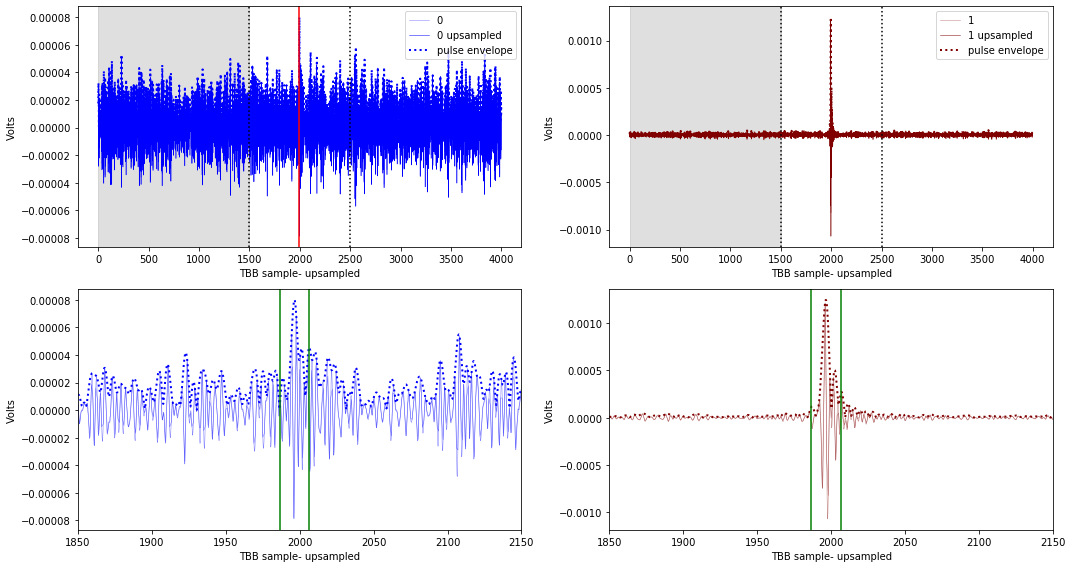

time delay:  0.0001683996875


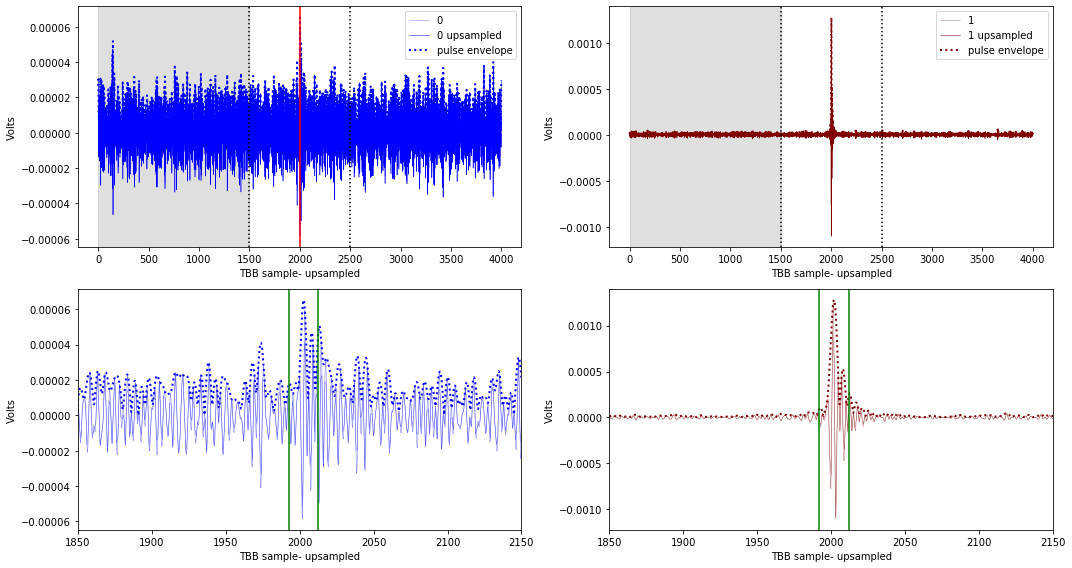

time delay:  0.00016842875


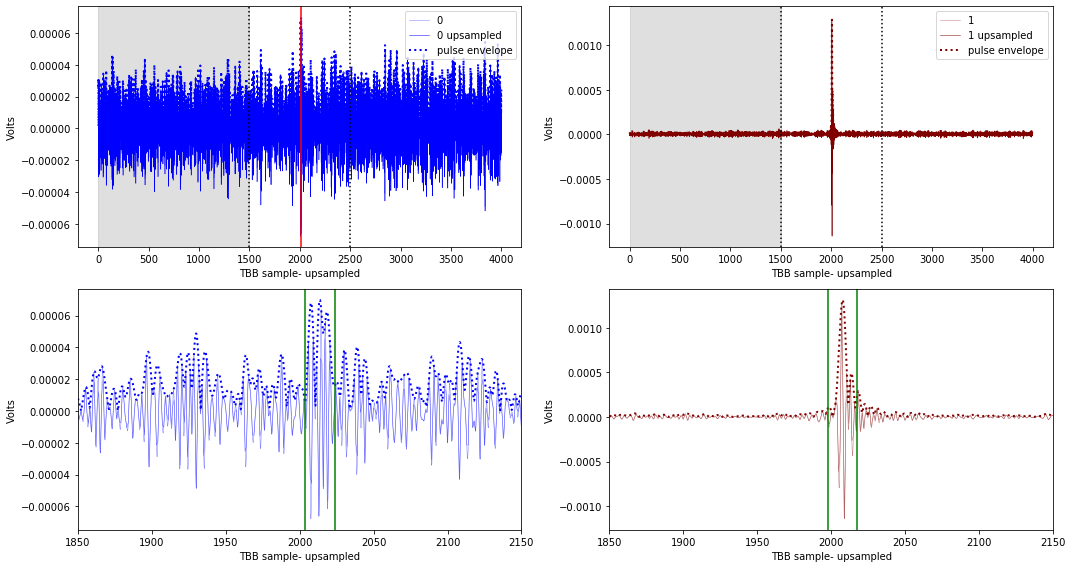

<ipython-input-170-f65995b32b18>:57: RuntimeWarning: invalid value encountered in double_scalars
  snr0[p]=peak0[p]/rms0[p]
<ipython-input-170-f65995b32b18>:58: RuntimeWarning: invalid value encountered in double_scalars
  snr1[p]=peak1[p]/rms1[p]


time delay:  0.00016589


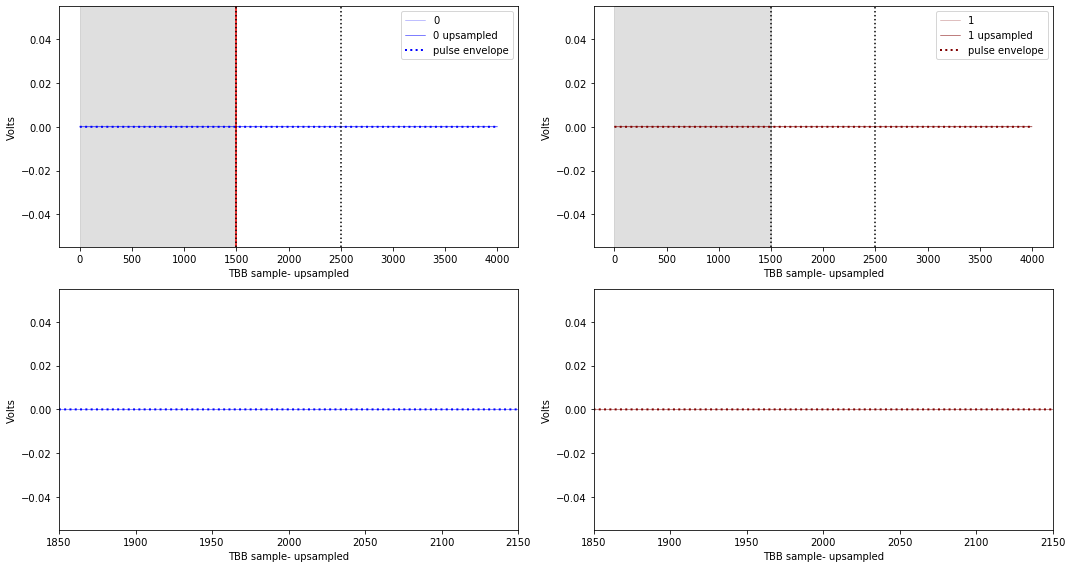

time delay:  0.00016848375


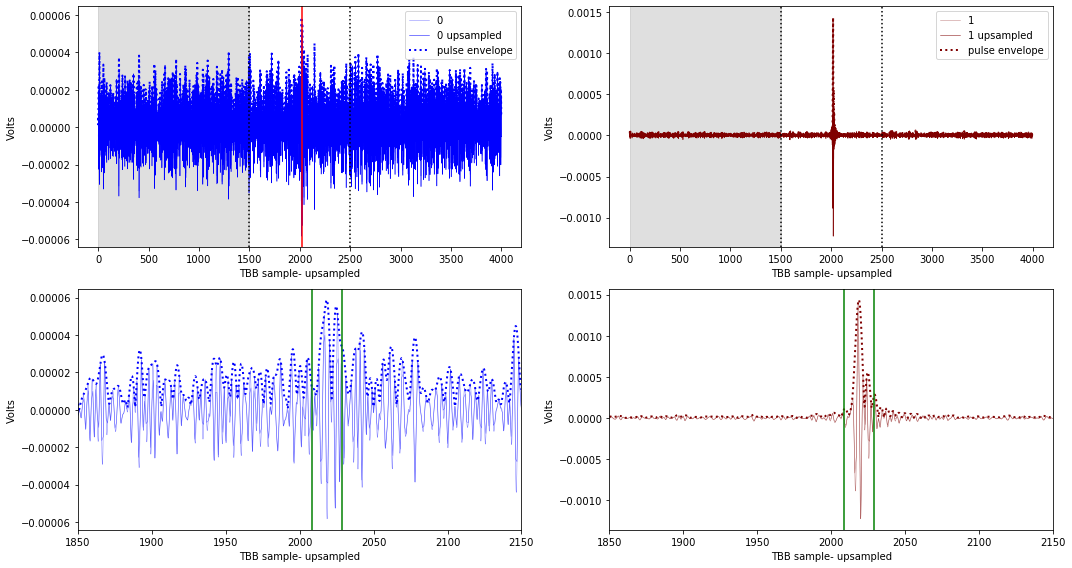

time delay:  0.00016851187500000001


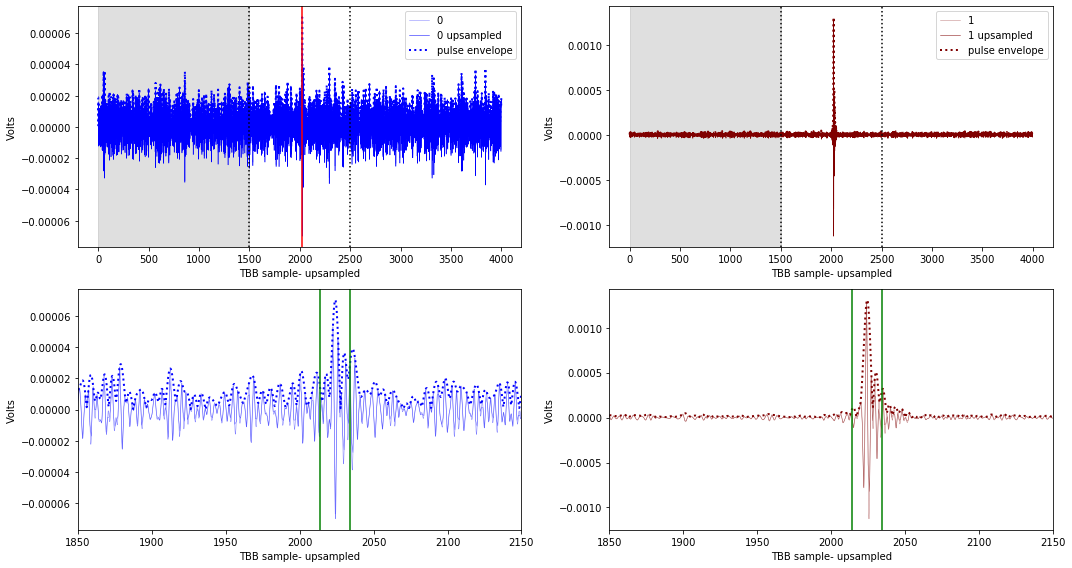

time delay:  0.00016589


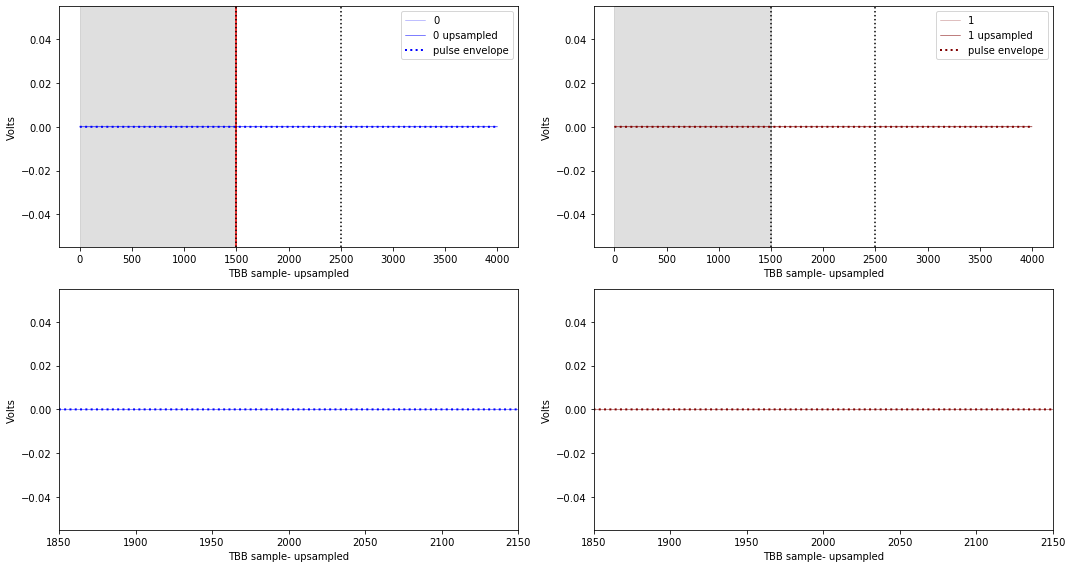

time delay:  0.000168515625


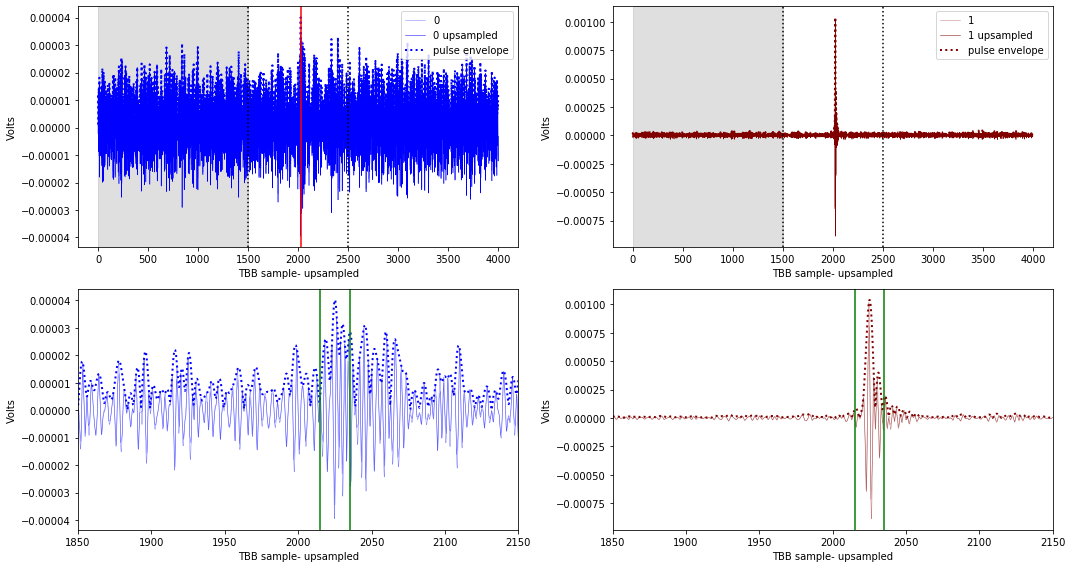

time delay:  0.00016850218750000002


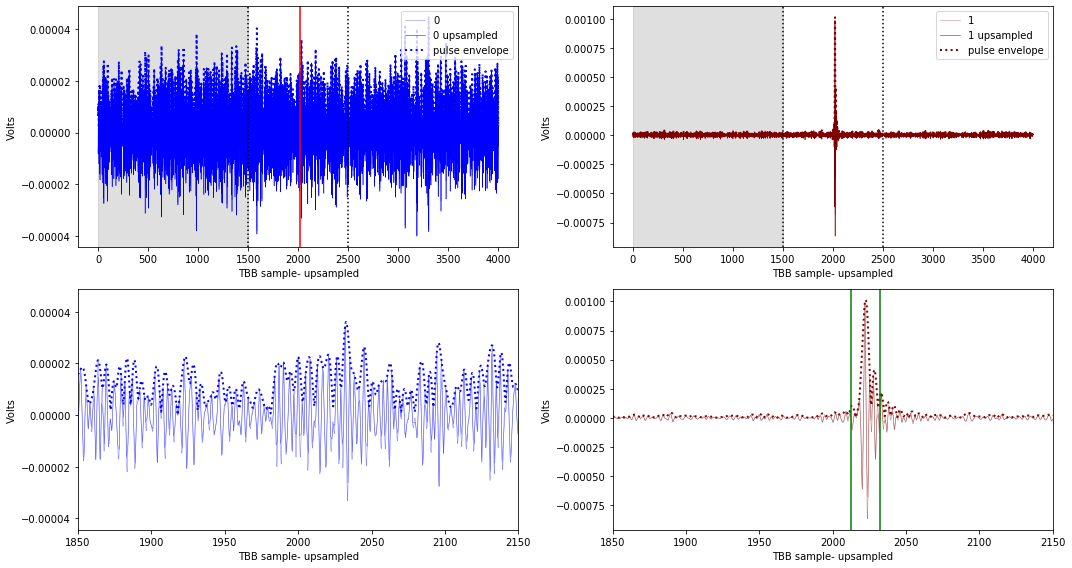

time delay:  0.00016846156250000001


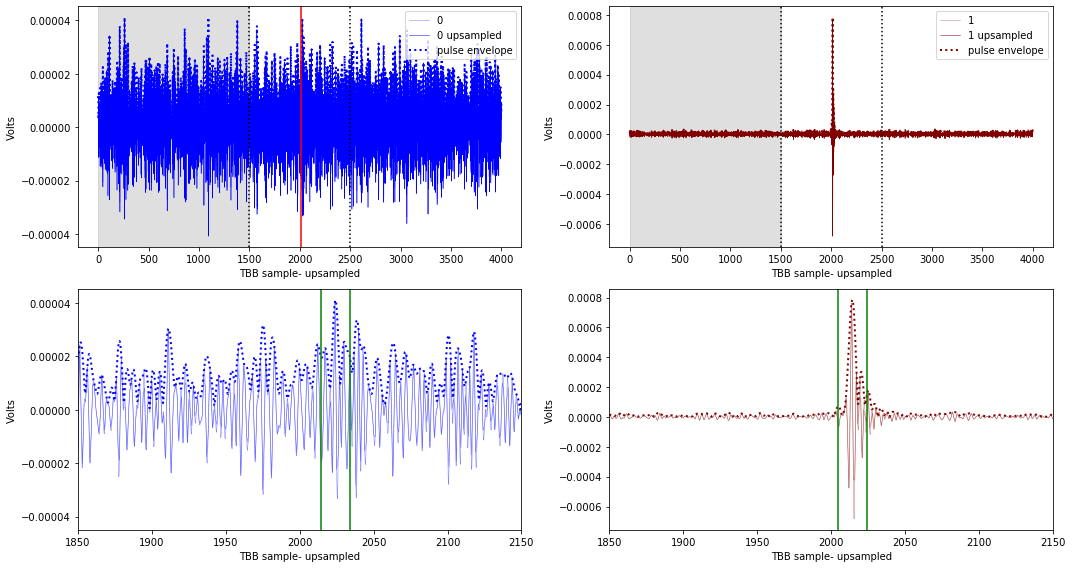

time delay:  0.0001684459375


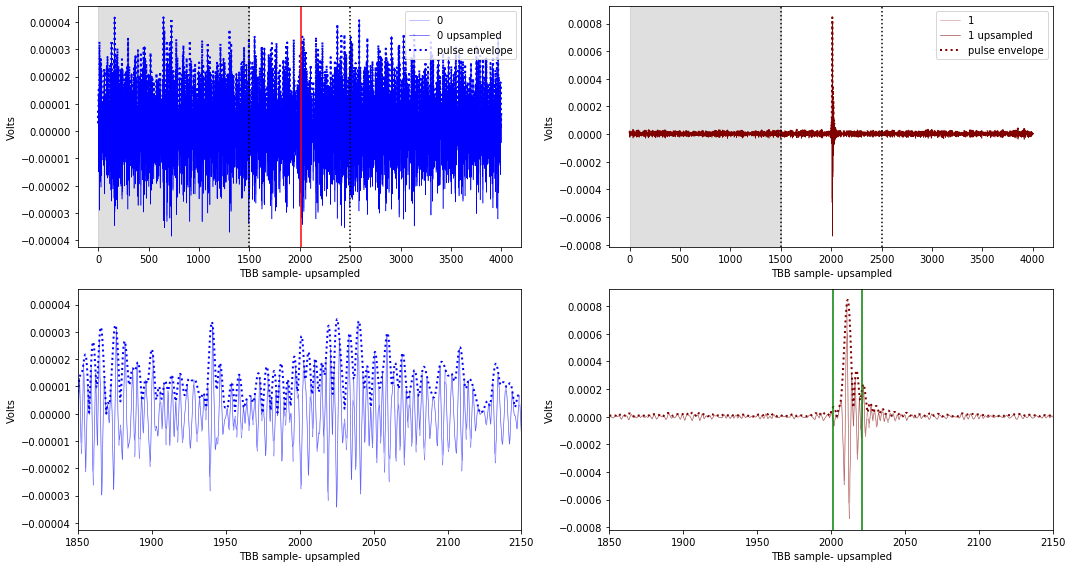

time delay:  0.0001684440625


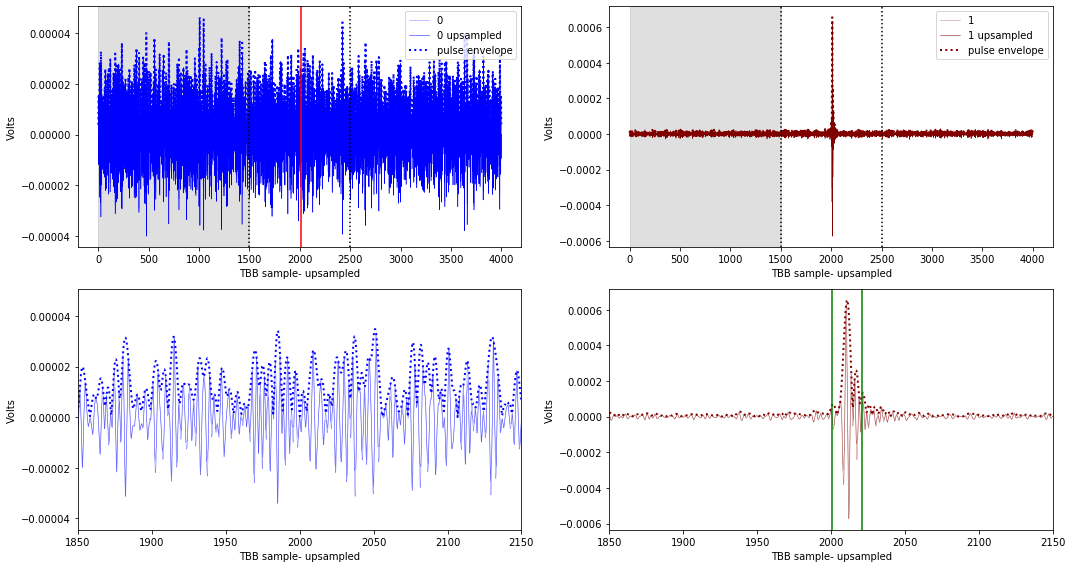

time delay:  0.00016835656250000001


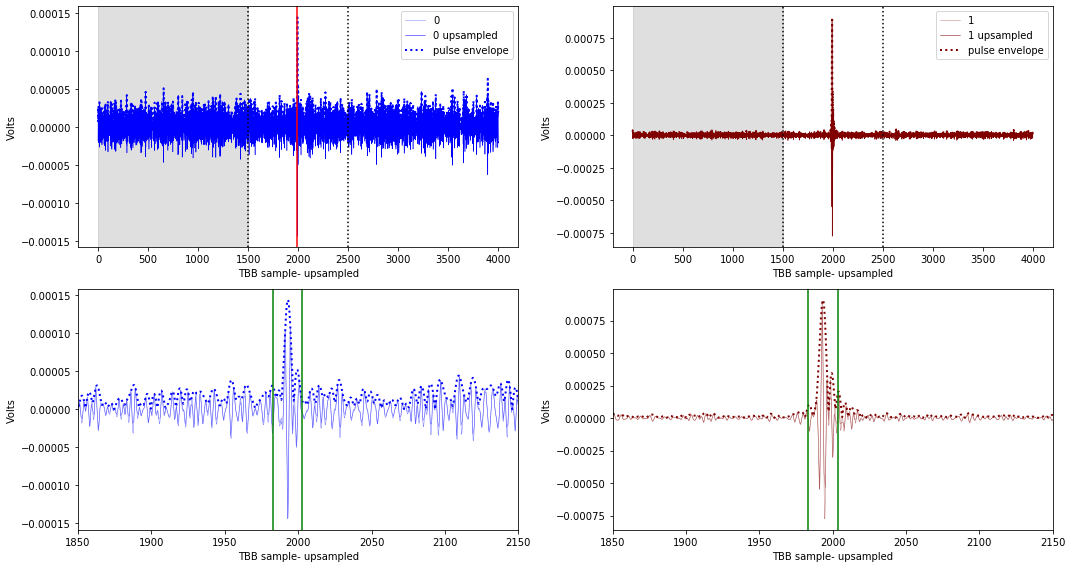

time delay:  0.00016834


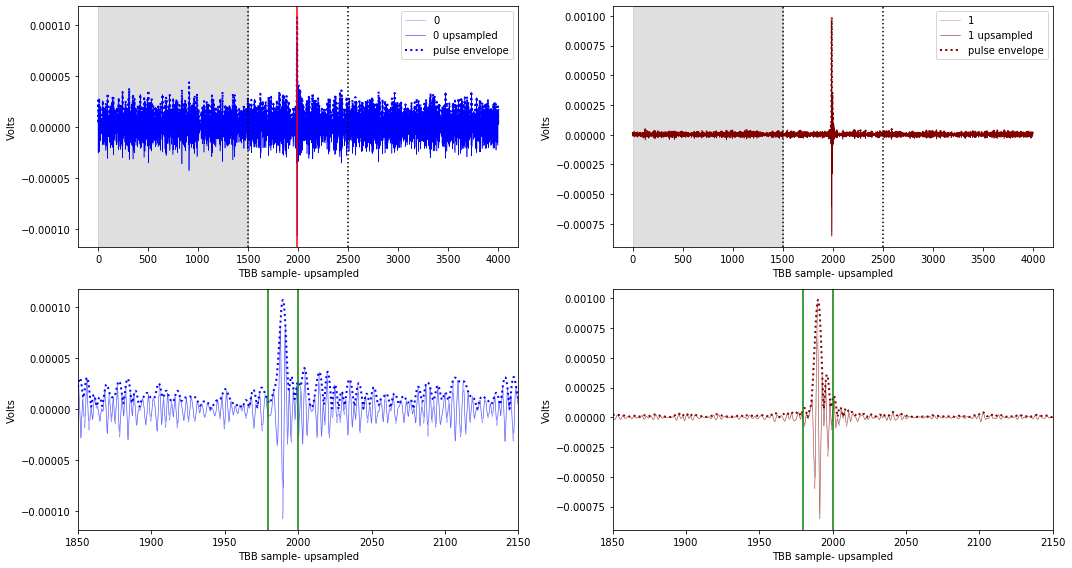

time delay:  0.0001683465625


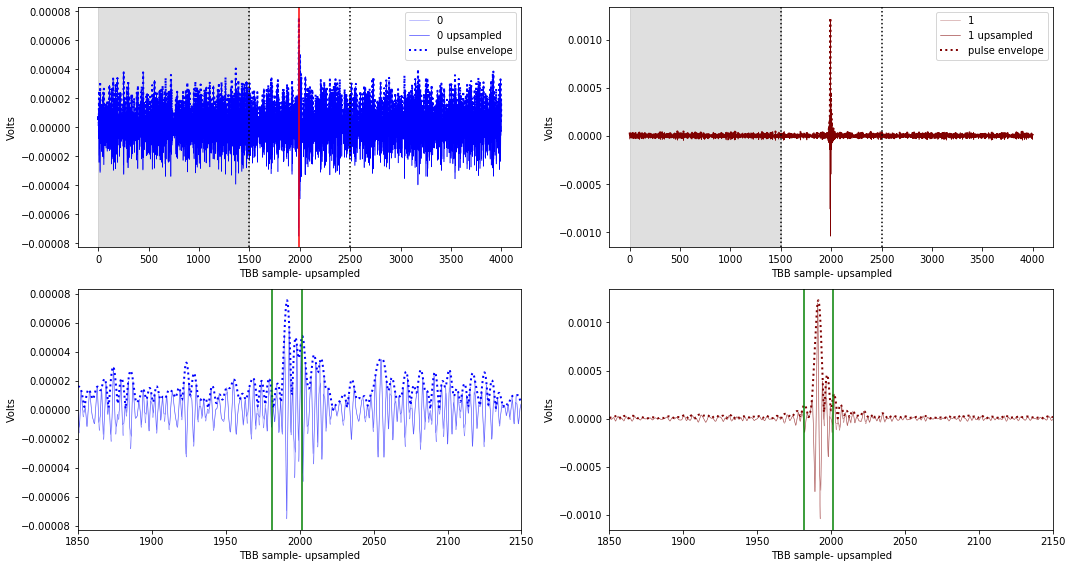

time delay:  0.00016837375


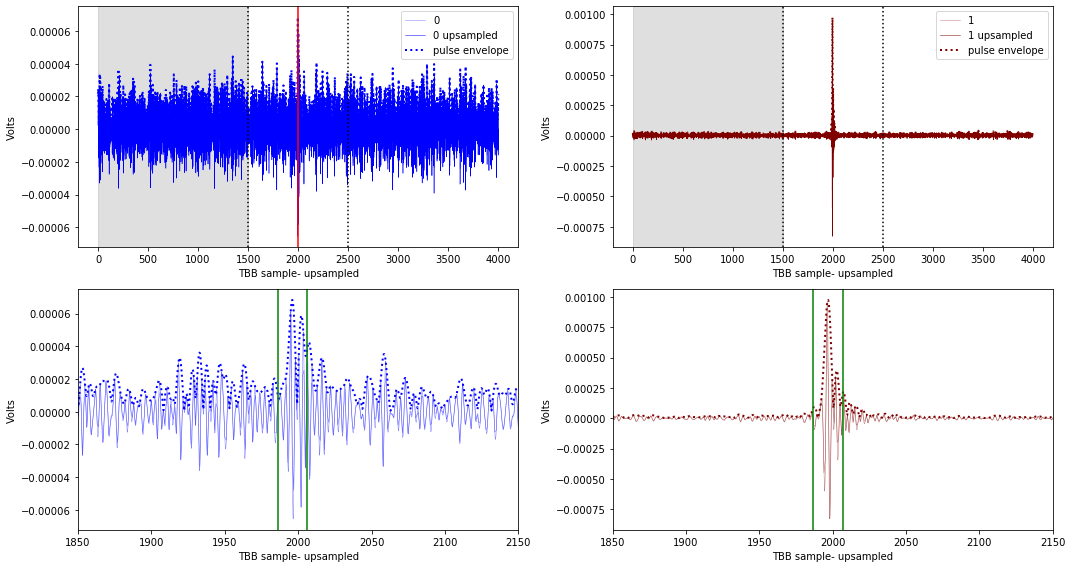

time delay:  0.0001684825


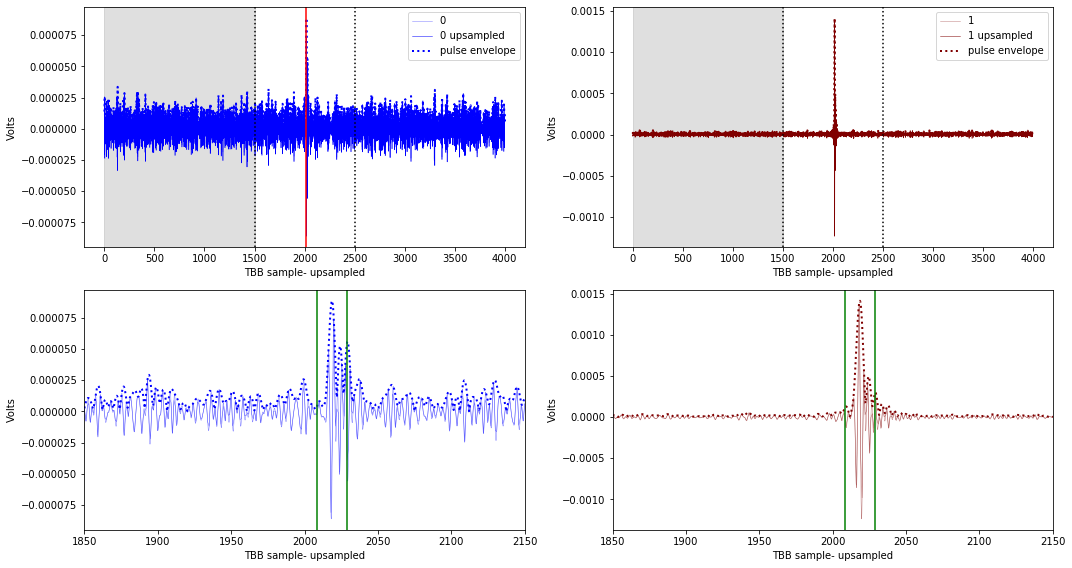

time delay:  0.000168513125


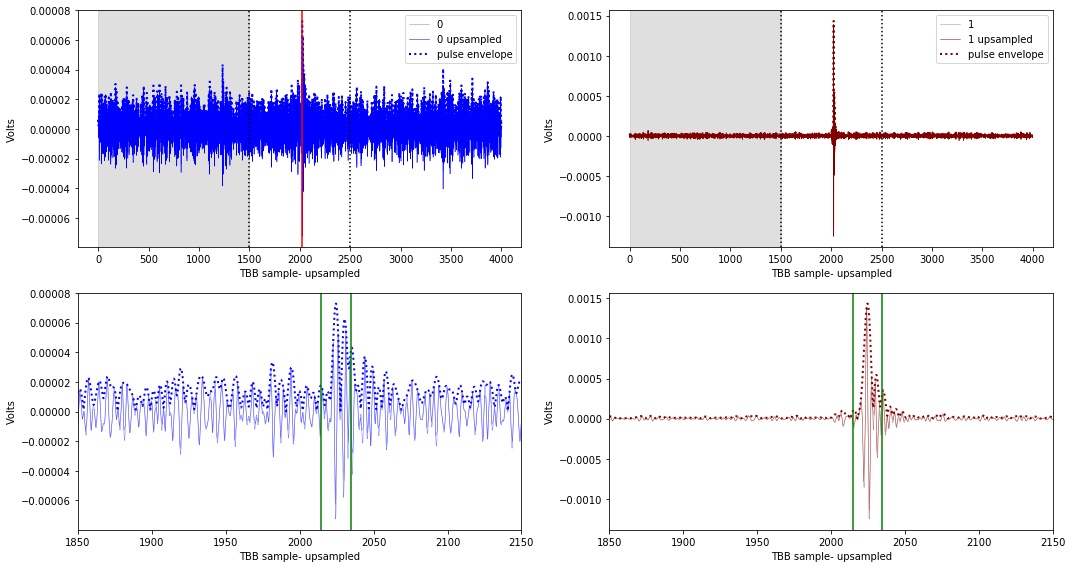

time delay:  0.000168535625


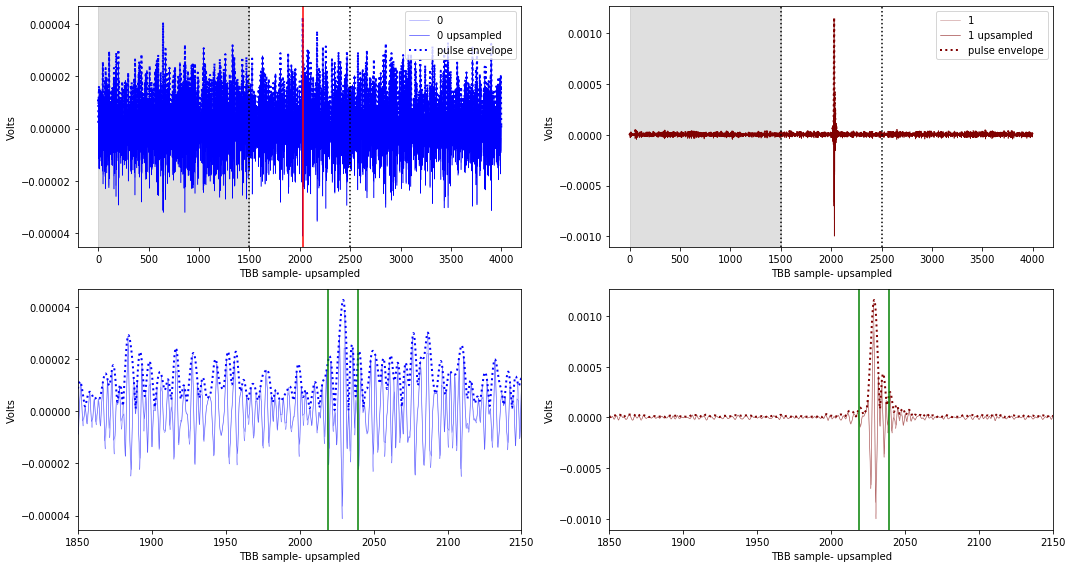

time delay:  0.0001684834375


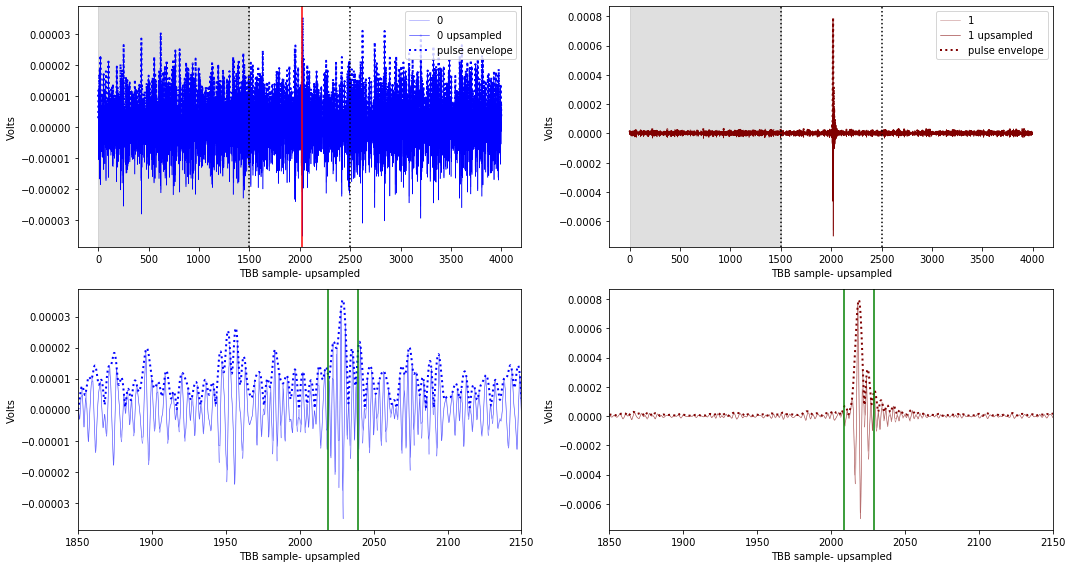

In [170]:

onsky_0,onsky_1=antenna_model.unfold_model(timeseries_0,timeseries_1,new_pulse_direction)

resample_factor=16

#peak0, peak1 from first beamforming

window_start=int(int(peak_pos-2000))  # i made up the window size
window_end=int(int(peak_pos+2000))

signal_window_start=int(int(peak_pos-500)-window_start)  # i made up the window size
signal_window_end=int(int(peak_pos+500)-window_start)

noise_window_start=int(0)
noise_window_end=1500

print('signal_window: {0} -> {1}'.format(signal_window_start,signal_window_end))
print('noise_window: {0} -> {1}'.format(0,int(mid-5000)))

ndipoles=int(nantennas/2)
delay=np.zeros([ndipoles])
rms0=np.zeros([ndipoles])
rms1=np.zeros([ndipoles])
peak0=np.zeros([ndipoles])
peak1=np.zeros([ndipoles])
snr0=np.zeros([ndipoles])
snr1=np.zeros([ndipoles])
integrated_pulse_power_0=np.zeros([ndipoles])
integrated_pulse_power_1=np.zeros([ndipoles])
integrated_noise_power_0=np.zeros([ndipoles])
integrated_noise_power_1=np.zeros([ndipoles])

for p in np.arange(ndipoles):
    # don't need to look at the whole trace
    signal_0=onsky_0[p][window_start:window_end]
    signal_1=onsky_1[p][window_start:window_end]

    f0 = signal.resample(signal_0, len(signal_0)*resample_factor)
    f1 = signal.resample(signal_1, len(signal_1)*resample_factor)

    xnew0 = np.linspace(0, len(signal_0), len(signal_0)*resample_factor, endpoint=False)
    xnew1 = np.linspace(0, len(signal_1), len(signal_1)*resample_factor, endpoint=False)

    # Apply Hilbert transform

    analytic_signal_0 = hilbert(f0)
    analytic_signal_1 = hilbert(f1)
    # get envelope
    amplitude_envelope_0 = np.abs(analytic_signal_0)
    amplitude_envelope_1 = np.abs(analytic_signal_1)

    # Find signal to noise ratio, maximum, position of maximum and rms
    
    rms0[p]=np.sqrt(np.mean((amplitude_envelope_0[resample_factor*noise_window_start:resample_factor*noise_window_end])**2))
    rms1[p]=np.sqrt(np.mean((amplitude_envelope_1[resample_factor*noise_window_start:resample_factor*noise_window_end])**2))
    peak0[p]=np.max(amplitude_envelope_0[resample_factor*signal_window_start:resample_factor*signal_window_end])
    peak1[p]=np.max(amplitude_envelope_1[resample_factor*signal_window_start:resample_factor*signal_window_end])
    snr0[p]=peak0[p]/rms0[p]
    snr1[p]=peak1[p]/rms1[p]
    
    # find time delay from start of block
    
    position_of_max0=np.argmax(amplitude_envelope_0[resample_factor*signal_window_start:resample_factor*signal_window_end])
    position_of_max1=np.argmax(amplitude_envelope_1[resample_factor*signal_window_start:resample_factor*signal_window_end])
        
    if dominant_pol==0:
        position_of_max=position_of_max0
    else:
        position_of_max=position_of_max1
    # find in terms of original sampling
    position_of_max=(position_of_max/resample_factor+signal_window_start)+window_start
        

    
   
    delay[p]=position_of_max*5e-9
    print('time delay: ',delay[p])
    
    # find integrated pulse power
    # this window doesn't seem big enough!
    Z0 = 376.730
    integrated_pulse_power_0[p]=np.sum(signal_0[int((position_of_max/resample_factor+signal_window_start))-10:int((position_of_max/resample_factor+signal_window_start))+10]**2)
    integrated_pulse_power_1[p]=np.sum(signal_0[int((position_of_max/resample_factor+signal_window_start))-10:int((position_of_max/resample_factor+signal_window_start))+10]**2)

    integrated_noise_power_0[p]=np.sum(signal_0[noise_window_start:noise_window_end]**2)/(noise_window_end-noise_window_start)
    integrated_noise_power_1[p]=np.sum(signal_0[noise_window_start:noise_window_end]**2)/(noise_window_end-noise_window_start)
    
    integrated_pulse_power_0[p]=(integrated_pulse_power_0[p]-integrated_noise_power_0[p]*21.0)*5e-9/Z0
    integrated_pulse_power_1[p]=(integrated_pulse_power_1[p]-integrated_noise_power_0[p]*21.0)*5e-9/Z0
                                
    
    fig=plt.figure(facecolor='white',figsize=(15,8))
    ax1=fig.add_subplot(2,2,1)
    ax2=fig.add_subplot(2,2,2)

    ax3=fig.add_subplot(2,2,3)
    ax4=fig.add_subplot(2,2,4)

    ax1.plot(signal_0,color='blue',linewidth=0.5,alpha=0.5,label='0')
    ax1.plot(xnew0,f0,color='blue',linewidth=0.5,alpha=1,label='0 upsampled')
    ax1.plot(xnew1,amplitude_envelope_0,color='blue',linewidth=2,linestyle=':',label='pulse envelope')


    ax2.plot(signal_1,color='maroon',linewidth=0.5,alpha=0.5,label='1')
    ax2.plot(xnew1,f1,color='maroon',linewidth=0.5,alpha=1,label='1 upsampled')
    ax2.plot(xnew1,amplitude_envelope_1,color='maroon',linewidth=2,linestyle=':',label='pulse envelope')
    
    ax1.set_xlabel('TBB sample- upsampled',fontsize=10)
    ax1.set_ylabel('Volts',fontsize=10)

    ax2.set_xlabel('TBB sample- upsampled',fontsize=10)
    ax2.set_ylabel('Volts',fontsize=10)


    ax3.plot(signal_0,color='blue',linewidth=0.5,alpha=0.5,label='0')
    ax3.plot(xnew0,f0,color='blue',linewidth=0.5,alpha=0.5,label='0 upsampled')
    ax3.plot(xnew1,amplitude_envelope_0,color='blue',linewidth=2,linestyle=':',label='pulse envelope')


    ax4.plot(signal_1,color='maroon',linewidth=0.5,alpha=0.5,label='1')
    ax4.plot(xnew1,f1,color='maroon',linewidth=0.5,alpha=0.5,label='1 upsampled')
    ax4.plot(xnew1,amplitude_envelope_1,color='maroon',linewidth=2,linestyle=':',label='pulse envelope')

    ax3.set_xlabel('TBB sample- upsampled',fontsize=10)
    ax3.set_ylabel('Volts',fontsize=10)

    ax4.set_xlabel('TBB sample- upsampled',fontsize=10)
    ax4.set_ylabel('Volts',fontsize=10)

  

    ax1.axvspan(noise_window_start, noise_window_end, alpha=0.25, color='grey')
    ax2.axvspan(noise_window_start, noise_window_end, alpha=0.25, color='grey')


    ax1.legend(loc="upper right", fontsize=10)
    ax2.legend(loc="upper right", fontsize=10)
 
    #ax1.axvline(x=position_of_max-window_start, linestyle=':',color='black')
    ax1.axvline(x=position_of_max-window_start, linestyle='-',color='red')


    ax1.axvline(x=signal_window_start, linestyle=':',color='black')
    ax2.axvline(x=signal_window_start, linestyle=':',color='black')
    ax3.axvline(x=signal_window_start, linestyle=':',color='black')
    ax4.axvline(x=signal_window_start, linestyle=':',color='black')
    ax1.axvline(x=signal_window_end, linestyle=':',color='black')
    ax2.axvline(x=signal_window_end, linestyle=':',color='black')
    ax3.axvline(x=signal_window_end, linestyle=':',color='black')
    ax4.axvline(x=signal_window_end, linestyle=':',color='black')
    
    
    ax3.axvline(x=(position_of_max0/resample_factor+signal_window_start)-10, linestyle='-',color='green')
    ax3.axvline(x=(position_of_max0/resample_factor+signal_window_start)+10, linestyle='-',color='green')
    ax4.axvline(x=(position_of_max1/resample_factor+signal_window_start)-10, linestyle='-',color='green')
    ax4.axvline(x=(position_of_max1/resample_factor+signal_window_start)+10, linestyle='-',color='green')

    

    ax3.set_xlim(signal_window_start+350,signal_window_end-350)
    ax4.set_xlim(signal_window_start+350,signal_window_end-350)

    plt.tight_layout()
    plt.show()
    



In [51]:
imp.reload(planewave)

<module 'planewave' from '/vol/astro7/lofar/kmulrey/test_pipeline/scripts/planewave.py'>

In [171]:
c = 299792458.0  # speed of light in m/s
rad2deg = 180.0 / np.pi

if dominant_pol==0:
    goodtimes=delay[snr0>3]
    goodpositions=positions_0[snr0>3]
    #goodantennas=allantennas[snr0>3]
else:
    goodtimes=delay[snr1>3]
    goodpositions=positions_1[snr1>3]
    #goodantennas=allantennas[snr1>3]
    
goodtimes=goodtimes-goodtimes[0] # normalize to reference antenna
goodcount=len(goodtimes)
#check that at least 3 antennas are good
goodantennas=np.arange(goodcount)

indicesOfGoodAntennas=goodantennas
goodtimes_fit=goodtimes
goodpositions_fit=goodpositions
# iterively remove antennas for best fit
while True:
    goodcount=len(indicesOfGoodAntennas)
    (az, el) = planewave.directionForHorizontalArray(goodpositions_fit.ravel(), goodtimes_fit)
    print(180/np.pi*az%360,180/np.pi*el)
    expectedDelays = planewave.timeDelaysFromDirection(goodpositions_fit.ravel(), (az, el))
    expectedDelays -= expectedDelays[0]
    residual_delays = goodtimes_fit - expectedDelays
    spread = np.std(residual_delays)
    k = 2 #rms factor
    goodSubset = np.where(abs(residual_delays - np.mean(residual_delays)) < k * spread)
    if len(goodSubset[0]) == goodcount:
        break
    else:
        goodcount = len(goodSubset[0])
        tmp = indicesOfGoodAntennas[goodSubset[0]]
        indicesOfGoodAntennas=tmp
        goodpositions_fit=goodpositions[indicesOfGoodAntennas]
        goodtimes_fit=goodtimes[indicesOfGoodAntennas]


300.85916564828335 43.20266618799363
301.1350190159171 43.39041525740012
301.1281218003583 43.50764961885024
300.9666673469983 43.433871112949944
300.9450304108233 43.49248212399982
300.89180336163463 43.56277255215088
300.8526243131963 43.650224102205804


<ipython-input-171-5f7fbef8b078>:9: RuntimeWarning: invalid value encountered in greater
  goodtimes=delay[snr1>3]
<ipython-input-171-5f7fbef8b078>:10: RuntimeWarning: invalid value encountered in greater
  goodpositions=positions_1[snr1>3]


In [172]:
print(180/np.pi*az%360,180/np.pi*el)

300.8526243131963 43.650224102205804


In [173]:
cartesianDirection = [np.cos(el) * np.sin(az), np.cos(el) * np.cos(az), np.sin(el)]
meanDirection=cartesianDirection

In [174]:
#redo and save for all antennas
expectedDelays = planewave.timeDelaysFromDirection(goodpositions.ravel(), (az, el))  # need positions as flat 1-D array
expectedDelays -= expectedDelays[0]  # subtract ref ant


In [47]:
def spaceAngle(zen1, az1, zen2, az2):
    """
     Calculates space angle between two sets of angles (convetion kartesian)
    """
    return np.arccos(np.sin(zen1) * np.sin(zen2) * np.cos(az1 - az2)
                + np.cos(zen1) * np.cos(zen2))



In [48]:
#check that fit converges
maximum_angular_diff=0.5
pulse_direction=(az, el)
last_direction=new_pulse_direction
angular_diff = np.rad2deg(spaceAngle(np.deg2rad((90 - last_direction[1])), np.deg2rad((90 - last_direction[0])), np.deg2rad((90 - pulse_direction[1])), np.deg2rad((90 - pulse_direction[0]))))
print(angular_diff)


60.8860954301279


In [49]:
# right now continue to work with un phase corrected data
#do the flip after antenna model to be consistent
'''
if TBB_data.antennaSet=="LBA_OUTER":
    tmp=np.zeros_like(data)
    tmp[::2,:]=calibrated_data[1::2,:]
    tmp[1::2,:]=calibrated_data[::2,:]
    timeseries_data=tmp
else:
    timeseries_data=calibrated_data
'''
timeseries_data=calibrated_data

## find integrated power for station (xyz, 01), find stoke's parameters

## Save all data for this station

# with data from all stations

* run LDF
* do polarization
* run wavefront

# swap dipoles for LBA outer? 
Is this needed or is it handled in Brian's code?

In [ ]:
fig=plt.figure(facecolor='white',figsize=(5,5))
ax1=fig.add_subplot(1,1,1,aspect=1)

ax1.plot(positions.T[0],positions.T[1],color='black',marker='o',linestyle='none')

ax1.set_xlabel('x(m)',fontsize=10)
ax1.set_ylabel('y(m)',fontsize=10)
#ax1.set_ylim([-50, 50])
#ax1.set_ylim([1e-5, 1e1])

#plt.legend(loc="upper right", fontsize=10)

plt.show()